In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"

# Image properties
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Load dataset using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(DATASET_PATH, 
                                         target_size=(IMG_SIZE, IMG_SIZE), 
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',
                                         subset='training')

val_data = datagen.flow_from_directory(DATASET_PATH, 
                                       target_size=(IMG_SIZE, IMG_SIZE), 
                                       batch_size=BATCH_SIZE,
                                       class_mode='categorical',
                                       subset='validation')

# Mapping labels to alphabets
class_labels = {v: k for k, v in train_data.class_indices.items()}
print("Class Labels:", class_labels)


Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.
Class Labels: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'asl_dataset', 12: 'b', 13: 'c', 14: 'd', 15: 'e', 16: 'f', 17: 'g', 18: 'h', 19: 'i', 20: 'j', 21: 'k', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'q', 28: 'r', 29: 's', 30: 't', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'y', 36: 'z'}


In [2]:
from tensorflow.keras import layers, models

# Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')  # Output layer for classification
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
EPOCHS = 10
model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

# Save model
model.save("sign_language_model.h5")
print("✅ Model trained and saved!")

Epoch 1/10
126/126 [==============================] - 47s 354ms/step - loss: 2.0995 - accuracy: 0.4893 - val_loss: 1.7558 - val_accuracy: 0.3509
Epoch 2/10
126/126 [==============================] - 33s 265ms/step - loss: 1.0575 - accuracy: 0.5154 - val_loss: 1.9050 - val_accuracy: 0.1769
Epoch 3/10
126/126 [==============================] - 36s 284ms/step - loss: 0.9093 - accuracy: 0.5348 - val_loss: 1.9816 - val_accuracy: 0.2137
Epoch 4/10
126/126 [==============================] - 36s 290ms/step - loss: 0.8249 - accuracy: 0.5437 - val_loss: 2.5765 - val_accuracy: 0.1501
Epoch 5/10
126/126 [==============================] - 38s 301ms/step - loss: 0.7996 - accuracy: 0.5375 - val_loss: 2.2980 - val_accuracy: 0.1511
Epoch 6/10
126/126 [==============================] - 37s 296ms/step - loss: 0.7591 - accuracy: 0.5472 - val_loss: 2.5435 - val_accuracy: 0.1332
Epoch 7/10
126/126 [==============================] - 35s 281ms/step - loss: 0.7500 - accuracy: 0.5524 - val_loss: 2.7654 - val_ac

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("sign_language_model.h5")

# Open camera
cap = cv2.VideoCapture(0)

# List to store detected letters
detected_text = []

# Mapping class indices to letters
class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z', 26: ' '}  # 26 represents space

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize and preprocess the frame
    img = cv2.resize(frame, (64, 64))  # Resize to match model input
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize

    # Predict gesture
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    letter = class_labels[predicted_class]  # Convert to letter
    
    # Append letter if it's different from the last detected letter
    if len(detected_text) == 0 or detected_text[-1] != letter:
        detected_text.append(letter)
    
    # Display detected text in real-time
    formatted_text = " ".join("".join(detected_text).split())  # Remove extra spaces
    cv2.putText(frame, f"Text: {formatted_text}", (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow("Sign Language Recognition", frame)
    
    # Keyboard controls:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Quit program
        break
    elif key == ord('c'):  # Clear text
        detected_text = []
        print("\n🟢 Text cleared! Start again.\n")

cap.release()
cv2.destroyAllWindows()

# Print final detected text
final_output = " ".join("".join(detected_text).split())  # Format output
print("\n✅ Final Recognized Text:\n" + "="*30 + f"\n{final_output}\n" + "="*30)

In [1]:
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to datasets (modify for Google Drive if using Colab)
dataset_paths = ["C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"]

# Image parameters
IMG_SIZE = 64  
BATCH_SIZE = 32  

# Data Augmentation & Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  # Rotate images slightly
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1,  # Shift images vertically
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Zoom transformation
    horizontal_flip=True  # Flip images horizontally
)

# Load datasets
train_generators = []
val_generators = []

for path in dataset_paths:
    train_generators.append(data_gen.flow_from_directory(
        path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training"
    ))
    val_generators.append(data_gen.flow_from_directory(
        path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation"
    ))

# Compute steps per epoch
train_steps = sum(len(gen) for gen in train_generators)
val_steps = sum(len(gen) for gen in val_generators)

# Combine all train and validation generators
def generator_wrapper(generators):
    for gen in generators:
        for x, y in gen:
            yield x, y

train_data = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(train_generators),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generators[0].class_indices)), dtype=tf.float32)
    )
)

val_data = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(val_generators),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(val_generators[0].class_indices)), dtype=tf.float32)
    )
)

# Build Optimized CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),  # Helps prevent overfitting
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_generators[0].class_indices), activation='softmax')  
])

# Compile Model with Lower Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Custom Callback for Training Time
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"\n⏳ Estimated time per epoch: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Early Stopping to Prevent Overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model
EPOCHS = 10
model.fit(
    train_data,
    validation_data=val_data,
    steps_per_epoch=train_steps,  
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), early_stopping]
)

# Save Model
model.save("sign_language_model.h5")
print("✅ Model trained and saved!")

Found 190472 images belonging to 39 classes.
Found 47602 images belonging to 39 classes.
Epoch 1/10
5952/5953 [============================>.] - ETA: 0s - loss: 2.2990 - accuracy: 0.3800
⏳ Estimated time per epoch: 1702.81 seconds (28.38 minutes)
5953/5953 [==============================] - 1703s 286ms/step - loss: 2.2990 - accuracy: 0.3800 - val_loss: 1.9193 - val_accuracy: 0.5753
Epoch 2/10
5952/5953 [============================>.] - ETA: 0s - loss: 1.5794 - accuracy: 0.6197
⏳ Estimated time per epoch: 1404.61 seconds (23.41 minutes)
5953/5953 [==============================] - 1405s 236ms/step - loss: 1.5794 - accuracy: 0.6197 - val_loss: 1.7536 - val_accuracy: 0.6561
Epoch 3/10
5952/5953 [============================>.] - ETA: 0s - loss: 1.3798 - accuracy: 0.6932
⏳ Estimated time per epoch: 1485.12 seconds (24.75 minutes)
5953/5953 [==============================] - 1485s 250ms/step - loss: 1.3798 - accuracy: 0.6932 - val_loss: 1.6450 - val_accuracy: 0.7049
Epoch 4/10
5952/5953 [=

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model trained and saved!


In [ ]:
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("sign_language_model.h5")
print("\u2705 Loaded previously trained model!")

# Define paths to dataset
dataset_paths = ["C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/", 
                "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"]

# Image parameters
IMG_SIZE = 64  
BATCH_SIZE = 32  

# Enhanced Data Augmentation & Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,  # Increased rotation for better variability
    width_shift_range=0.2,  # Increased shift range
    height_shift_range=0.2,
    shear_range=0.2,  # Increased shear
    zoom_range=0.2,  # Increased zoom
    horizontal_flip=True  # Keep flipping
)

# Load datasets
train_generators = []
val_generators = []

for path in dataset_paths:
    train_generators.append(data_gen.flow_from_directory(
        path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training"
    ))
    val_generators.append(data_gen.flow_from_directory(
        path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation"
    ))

# Compute steps per epoch
train_steps = sum(len(gen) for gen in train_generators)
val_steps = sum(len(gen) for gen in val_generators)

# Combine all train and validation generators
def generator_wrapper(generators):
    for gen in generators:
        for x, y in gen:
            yield x, y

train_data = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(train_generators),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generators[0].class_indices)), dtype=tf.float32)
    )
)

val_data = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(val_generators),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(val_generators[0].class_indices)), dtype=tf.float32)
    )
)

# Reduce learning rate for fine-tuning
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Custom Callback for Training Time
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"\n\u23F3 Estimated time per epoch: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# Early Stopping to Prevent Overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modify dropout in the model for better regularization
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.rate = 0.4  # Increase dropout rate to 40%

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue Training the Model
EPOCHS = 50  # Reduce to avoid overfitting
model.fit(
    train_data,
    validation_data=val_data,
    steps_per_epoch=train_steps,  
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), lr_scheduler, early_stopping]
)

# Save Updated Model
model.save("sign_language_model_v2.h5")
print("\u2705 Model further trained and saved as sign_language_model_v2.h5!")

✅ Loaded previously trained model!
Found 190472 images belonging to 39 classes.
Found 47602 images belonging to 39 classes.
Found 44400 images belonging to 37 classes.
Found 11100 images belonging to 37 classes.
Epoch 1/50
7341/7341 [==============================] - ETA: 0s - loss: 1.5669 - accuracy: 0.6347
⏳ Estimated time per epoch: 1874.84 seconds (31.25 minutes)
7341/7341 [==============================] - 1875s 255ms/step - loss: 1.5669 - accuracy: 0.6347 - val_loss: 1.6919 - val_accuracy: 0.6863 - lr: 3.0000e-04
Epoch 2/50
7341/7341 [==============================] - ETA: 0s - loss: 1.4514 - accuracy: 0.6645
⏳ Estimated time per epoch: 1870.33 seconds (31.17 minutes)
7341/7341 [==============================] - 1870s 255ms/step - loss: 1.4514 - accuracy: 0.6645 - val_loss: 1.7733 - val_accuracy: 0.6796 - lr: 3.0000e-04
Epoch 3/50
7341/7341 [==============================] - ETA: 0s - loss: 1.4072 - accuracy: 0.6776
⏳ Estimated time per epoch: 1835.20 seconds (30.59 minutes)
7341

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import time
import mediapipe as mp
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"
PROCESSED_DATA_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/Processed dataset/"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

# Step 1: Hand Detection and Cropping Function with Thresholding
def detect_and_crop_hand(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Convert to binary
    image_rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for MediaPipe
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        h, w = binary.shape
        x_coords = [landmark.x for landmark in hand_landmarks.landmark]
        y_coords = [landmark.y for landmark in hand_landmarks.landmark]
        xmin = max(0, int(min(x_coords) * w) - 20)
        xmax = min(w, int(max(x_coords) * w) + 20)
        ymin = max(0, int(min(y_coords) * h) - 20)
        ymax = min(h, int(max(y_coords) * h) + 20)
        cropped = binary[ymin:ymax, xmin:xmax]
    else:
        cropped = binary  # If no hand detected, use full image
    
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))

# Step 2: Preprocess Dataset
print("🔄 Preprocessing dataset with hand detection and thresholding...")
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)
    save_dir = os.path.join(PROCESSED_DATA_PATH, label)
    os.makedirs(save_dir, exist_ok=True)
    
    for i, file in enumerate(os.listdir(label_path)):
        img_path = os.path.join(label_path, file)
        img = cv2.imread(img_path)
        
        if img is not None:
            processed_img = detect_and_crop_hand(img)
            cv2.imwrite(os.path.join(save_dir, f"{i}.jpg"), processed_img)

print("✅ Preprocessing complete.")

# Step 3: Data Augmentation (Grayscale Handling)
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def grayscale_loader(directory, target_size, batch_size, subset):
    return data_gen.flow_from_directory(
        directory, target_size=target_size, batch_size=batch_size,
        color_mode='grayscale', class_mode='categorical', subset=subset
    )

train_data = grayscale_loader(PROCESSED_DATA_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "training")
val_data = grayscale_loader(PROCESSED_DATA_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "validation")

# Step 4: Build Model (Grayscale Input)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 5: Callbacks
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"\n⏳ Epoch time: {elapsed_time:.2f}s ({elapsed_time/60:.2f} mins)")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6
)

# Step 6: Train Model
EPOCHS = 50
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), early_stopping, lr_scheduler]
)

# Step 7: Save Model
model.save("sign_language_modelv2.h5")
print("✅ Model trained and saved as 'sign_language_modelv2.h5'")

🔄 Preprocessing dataset with hand detection and thresholding...
✅ Preprocessing complete.
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.
Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 3.8373 - accuracy: 0.0552
⏳ Epoch time: 11.03s (0.18 mins)
63/63 [==============================] - 11s 151ms/step - loss: 3.8373 - accuracy: 0.0552 - val_loss: 3.5625 - val_accuracy: 0.1252 - lr: 5.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 3.1469 - accuracy: 0.1799
⏳ Epoch time: 8.34s (0.14 mins)
63/63 [==============================] - 8s 132ms/step - loss: 3.1469 - accuracy: 0.1799 - val_loss: 2.5908 - val_accuracy: 0.2942 - lr: 5.0000e-04
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 2.5371 - accuracy: 0.2942
⏳ Epoch time: 8.26s (0.14 mins)
63/63 [==============================] - 8s 131ms/step - loss: 2.5371 - accuracy: 0.2942 - val_loss: 2.1746 - val_accuracy: 0.3777 - lr: 5.0000e-04
E

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import tensorflow as tf
import cv2
import numpy as np
import time
import mediapipe as mp
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
PROCESSED_DATA_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Processed dataset/"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

# Step 1: Hand Detection and Cropping Function with Thresholding
def detect_and_crop_hand(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Convert to binary
    image_rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)  # Convert back to RGB for MediaPipe
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        h, w = binary.shape
        x_coords = [landmark.x for landmark in hand_landmarks.landmark]
        y_coords = [landmark.y for landmark in hand_landmarks.landmark]
        xmin = max(0, int(min(x_coords) * w) - 20)
        xmax = min(w, int(max(x_coords) * w) + 20)
        ymin = max(0, int(min(y_coords) * h) - 20)
        ymax = min(h, int(max(y_coords) * h) + 20)
        cropped = binary[ymin:ymax, xmin:xmax]
    else:
        cropped = binary  # If no hand detected, use full image
    
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))

# Step 2: Preprocess Dataset
print("🔄 Preprocessing dataset with hand detection and thresholding...")
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)
    save_dir = os.path.join(PROCESSED_DATA_PATH, label)
    os.makedirs(save_dir, exist_ok=True)
    
    for i, file in enumerate(os.listdir(label_path)):
        img_path = os.path.join(label_path, file)
        img = cv2.imread(img_path)
        
        if img is not None:
            processed_img = detect_and_crop_hand(img)
            cv2.imwrite(os.path.join(save_dir, f"{i}.jpg"), processed_img)

print("✅ Preprocessing complete.")

# Step 3: Data Augmentation (Grayscale Handling)
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def grayscale_loader(directory, target_size, batch_size, subset):
    return data_gen.flow_from_directory(
        directory, target_size=target_size, batch_size=batch_size,
        color_mode='grayscale', class_mode='categorical', subset=subset
    )

train_data = grayscale_loader(PROCESSED_DATA_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "training")
val_data = grayscale_loader(PROCESSED_DATA_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "validation")

# Step 4: Build Model (Grayscale Input)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🚀 Load previously saved model (if exists)
if os.path.exists("sign_language_modelv2.h5"):
    print("🔁 Loading previously saved model...")
    model = tf.keras.models.load_model("sign_language_modelv2.h5")

# Step 5: Callbacks
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"\n⏳ Epoch time: {elapsed_time:.2f}s ({elapsed_time/60:.2f} mins)")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6
)

# Step 6: Train Model
EPOCHS = 50
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), early_stopping, lr_scheduler]
)

# Step 7: Save Model
model.save("sign_language_modelv3.h5")
print("✅ Model trained and saved as 'sign_language_modelv3.h5'")

🔄 Preprocessing dataset with hand detection and thresholding...
✅ Preprocessing complete.
Found 43200 images belonging to 36 classes.
Found 10800 images belonging to 36 classes.
🔁 Loading previously saved model...
Epoch 1/50
1350/1350 [==============================] - ETA: 0s - loss: 1.9589 - accuracy: 0.4807
⏳ Epoch time: 187.78s (3.13 mins)
1350/1350 [==============================] - 188s 139ms/step - loss: 1.9589 - accuracy: 0.4807 - val_loss: 0.9616 - val_accuracy: 0.8133 - lr: 6.2500e-05
Epoch 2/50
1350/1350 [==============================] - ETA: 0s - loss: 1.0566 - accuracy: 0.7369
⏳ Epoch time: 188.24s (3.14 mins)
1350/1350 [==============================] - 188s 139ms/step - loss: 1.0566 - accuracy: 0.7369 - val_loss: 0.6248 - val_accuracy: 0.9035 - lr: 6.2500e-05
Epoch 3/50
1350/1350 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.8219
⏳ Epoch time: 180.94s (3.02 mins)
1350/1350 [==============================] - 181s 134ms/step - loss: 0.7853 - accu

Epoch 29/50
1350/1350 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9762
⏳ Epoch time: 212.11s (3.54 mins)
1350/1350 [==============================] - 212s 157ms/step - loss: 0.2114 - accuracy: 0.9762 - val_loss: 0.1707 - val_accuracy: 0.9908 - lr: 6.2500e-05
Epoch 30/50
1350/1350 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9778
⏳ Epoch time: 222.30s (3.70 mins)
1350/1350 [==============================] - 222s 165ms/step - loss: 0.2072 - accuracy: 0.9778 - val_loss: 0.1692 - val_accuracy: 0.9902 - lr: 6.2500e-05
Epoch 31/50
1350/1350 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9772
⏳ Epoch time: 211.51s (3.53 mins)
1350/1350 [==============================] - 212s 157ms/step - loss: 0.2054 - accuracy: 0.9772 - val_loss: 0.1706 - val_accuracy: 0.9900 - lr: 6.2500e-05
Epoch 32/50
1350/1350 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9780
⏳ Epoch time: 215.33s (3.59 mins)
1350/1

In [9]:
import tensorflow as tf
import cv2
import numpy as np
import time
import mediapipe as mp
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
CROPPED_DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/cropped_dataset/"

# Step 0: MediaPipe Setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

def detect_and_crop_hand(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = image.shape
        coords = [(int(landmark.x * w), int(landmark.y * h)) for landmark in results.multi_hand_landmarks[0].landmark]
        x_min = max(min([pt[0] for pt in coords]) - 20, 0)
        x_max = min(max([pt[0] for pt in coords]) + 20, w)
        y_min = max(min([pt[1] for pt in coords]) - 20, 0)
        y_max = min(max([pt[1] for pt in coords]) + 20, h)
        cropped = image[y_min:y_max, x_min:x_max]
        return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    else:
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # fallback

# Step 1: Preprocess & Save Cropped Dataset
def preprocess_dataset():
    if os.path.exists(CROPPED_DATASET_PATH):
        print("✅ Cropped dataset already exists. Skipping preprocessing.")
        return

    print("✂️ Preprocessing images and applying hand detection...")
    os.makedirs(CROPPED_DATASET_PATH, exist_ok=True)
    for class_name in tqdm(os.listdir(DATASET_PATH)):
        class_dir = os.path.join(DATASET_PATH, class_name)
        if not os.path.isdir(class_dir):
            continue
        os.makedirs(os.path.join(CROPPED_DATASET_PATH, class_name), exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            cropped = detect_and_crop_hand(image)
            save_path = os.path.join(CROPPED_DATASET_PATH, class_name, img_file)
            cv2.imwrite(save_path, cropped)

preprocess_dataset()

# Step 2: Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def rgb_loader(directory, target_size, batch_size, subset):
    return data_gen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        subset=subset,
        shuffle=True
    )

train_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "training")
val_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "validation")

# Step 3: Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 4: Load Previous Model if Exists
model_path = "sign_language_modelv4.h5"
if os.path.exists(model_path):
    print("🔁 Loading previously saved model...")
    model = tf.keras.models.load_model(model_path)

# Step 5: Callbacks
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        print(f"\n⏳ Epoch time: {elapsed:.2f}s ({elapsed / 60:.2f} mins)")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Step 6: Train Model
EPOCHS = 50
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), early_stopping, lr_scheduler]
)

# Step 7: Save Model
model.save("sign_language_modelv4.h5")
print(f"✅ Model trained and saved as 'sign_language_modelv4.h5'")

  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

✂️ Preprocessing images and applying hand detection...


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [24:51<00:00, 41.43s/it]


Found 43200 images belonging to 36 classes.
Found 10800 images belonging to 36 classes.
Epoch 1/50
1350/1350 [==============================] - ETA: 0s - loss: 1.4132 - accuracy: 0.6221
⏳ Epoch time: 239.82s (4.00 mins)
1350/1350 [==============================] - 240s 177ms/step - loss: 1.4132 - accuracy: 0.6221 - val_loss: 0.4822 - val_accuracy: 0.9342 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.8903
⏳ Epoch time: 248.01s (4.13 mins)
1350/1350 [==============================] - 248s 184ms/step - loss: 0.5743 - accuracy: 0.8903 - val_loss: 0.3562 - val_accuracy: 0.9684 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.9271
⏳ Epoch time: 247.46s (4.12 mins)
1350/1350 [==============================] - 247s 183ms/step - loss: 0.4619 - accuracy: 0.9271 - val_loss: 0.3574 - val_accuracy: 0.9621 - lr: 5.0000e-04
Epoch 4/50
1350/1350 [==============================] 

Epoch 29/50
1350/1350 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9905
⏳ Epoch time: 208.17s (3.47 mins)
1350/1350 [==============================] - 208s 154ms/step - loss: 0.1289 - accuracy: 0.9905 - val_loss: 0.1066 - val_accuracy: 0.9960 - lr: 1.2500e-04
Epoch 30/50
1350/1350 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9906
⏳ Epoch time: 210.38s (3.51 mins)
1350/1350 [==============================] - 210s 156ms/step - loss: 0.1277 - accuracy: 0.9906 - val_loss: 0.1061 - val_accuracy: 0.9968 - lr: 1.2500e-04
Epoch 31/50
1350/1350 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9900
⏳ Epoch time: 209.23s (3.49 mins)
1350/1350 [==============================] - 209s 155ms/step - loss: 0.1281 - accuracy: 0.9900 - val_loss: 0.1068 - val_accuracy: 0.9951 - lr: 1.2500e-04
Epoch 32/50
1350/1350 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9899
⏳ Epoch time: 209.45s (3.49 mins)

Epoch

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Cropped dataset already exists. Skipping preprocessing.
📸 Visualizing cropped samples...


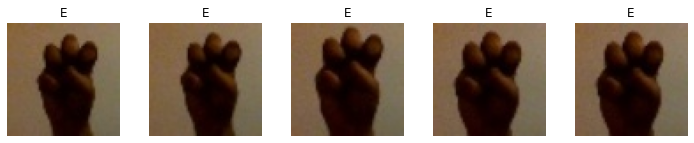

Found 43200 images belonging to 36 classes.
Found 10800 images belonging to 36 classes.
📄 Label map saved to 'label_map.json'.
⚖️ Computing class weights...
Epoch 1/50
1350/1350 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.8802
⏳ Epoch time: 712.24s (11.87 mins)
1350/1350 [==============================] - 712s 526ms/step - loss: 0.4427 - accuracy: 0.8802 - val_loss: 0.1825 - val_accuracy: 0.9376 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9833
⏳ Epoch time: 683.45s (11.39 mins)
1350/1350 [==============================] - 683s 506ms/step - loss: 0.0667 - accuracy: 0.9833 - val_loss: 1.3399 - val_accuracy: 0.7592 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9901
⏳ Epoch time: 682.69s (11.38 mins)

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1350/1350 [==============================] - 683s 506ms/ste

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import tensorflow as tf
import cv2
import numpy as np
import time
import mediapipe as mp
import os
import random
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
CROPPED_DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/cropped_dataset/"

# Step 0: MediaPipe Setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

def detect_and_crop_hand(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        h, w, _ = image.shape
        coords = [(int(landmark.x * w), int(landmark.y * h)) for landmark in results.multi_hand_landmarks[0].landmark]
        x_min = max(min([pt[0] for pt in coords]) - 20, 0)
        x_max = min(max([pt[0] for pt in coords]) + 20, w)
        y_min = max(min([pt[1] for pt in coords]) - 20, 0)
        y_max = min(max([pt[1] for pt in coords]) + 20, h)
        cropped = image[y_min:y_max, x_min:x_max]
        return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    else:
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # fallback

# Step 1: Preprocess & Save Cropped Dataset
def preprocess_dataset():
    if os.path.exists(CROPPED_DATASET_PATH):
        print("✅ Cropped dataset already exists. Skipping preprocessing.")
        return

    print("✂️ Preprocessing images and applying hand detection...")
    os.makedirs(CROPPED_DATASET_PATH, exist_ok=True)
    for class_name in tqdm(os.listdir(DATASET_PATH)):
        class_dir = os.path.join(DATASET_PATH, class_name)
        if not os.path.isdir(class_dir):
            continue
        os.makedirs(os.path.join(CROPPED_DATASET_PATH, class_name), exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            cropped = detect_and_crop_hand(image)
            save_path = os.path.join(CROPPED_DATASET_PATH, class_name, img_file)
            cv2.imwrite(save_path, cropped)

preprocess_dataset()

# Step 2: Visualize Cropped Samples (Randomly show 5)
def visualize_random_samples():
    print("📸 Visualizing cropped samples...")
    classes = os.listdir(CROPPED_DATASET_PATH)
    random_class = random.choice(classes)
    samples = os.listdir(os.path.join(CROPPED_DATASET_PATH, random_class))[:5]
    plt.figure(figsize=(10, 2))
    for i, sample in enumerate(samples):
        path = os.path.join(CROPPED_DATASET_PATH, random_class, sample)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(random_class)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_random_samples()

# Step 3: Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def rgb_loader(directory, target_size, batch_size, subset):
    return data_gen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        subset=subset,
        shuffle=True
    )

train_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "training")
val_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "validation")

# Step 4: Save Label Map
label_map_path = "label_map.json"
with open(label_map_path, "w") as f:
    json.dump(train_data.class_indices, f)
print("📄 Label map saved to 'label_map.json'.")

# Step 5: Compute Class Weights
print("⚖️ Computing class weights...")
y_train_labels = train_data.classes
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(weights))

# Step 6: Model Definition (With Batch Normalization)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 7: Load Existing Model if Available
model_path = "sign_language_modelv5.h5"
if os.path.exists(model_path):
    print("🔁 Loading existing model...")
    model = tf.keras.models.load_model(model_path)

# Step 8: Callbacks
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        print(f"\n⏳ Epoch time: {elapsed:.2f}s ({elapsed / 60:.2f} mins)")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Step 9: Train Model with Class Weights
EPOCHS = 50
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[TimeEstimator(), early_stopping, lr_scheduler],
    class_weight=class_weights_dict
)

# Step 10: Save Trained Model
model.save("sign_language_modelv5.h5")
print(f"✅ Model trained and saved as 'sign_language_modelv5.h5'")

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import time
import mediapipe as mp
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime

# Parameters
IMG_SIZE = 64
BATCH_SIZE = 32
DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
CROPPED_DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/cropped_dataset/"

# Step 0: MediaPipe Setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def detect_and_crop_hand(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = image.shape
        coords = [(int(lm.x * w), int(lm.y * h)) for lm in results.multi_hand_landmarks[0].landmark]
        x_min = max(min([pt[0] for pt in coords]) - 20, 0)
        x_max = min(max([pt[0] for pt in coords]) + 20, w)
        y_min = max(min([pt[1] for pt in coords]) - 20, 0)
        y_max = min(max([pt[1] for pt in coords]) + 20, h)
        cropped = image[y_min:y_max, x_min:x_max]
        return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE)), True
    else:
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE)), False  # fallback

# Step 1: Preprocess & Save Cropped Dataset
def preprocess_dataset():
    if os.path.exists(CROPPED_DATASET_PATH):
        print("✅ Cropped dataset already exists. Skipping preprocessing.")
        hands.close()
        return

    print("✂️ Preprocessing images and applying hand detection...")
    os.makedirs(CROPPED_DATASET_PATH, exist_ok=True)
    fallback_count = 0
    total_images = 0

    for class_name in tqdm(os.listdir(DATASET_PATH)):
        class_dir = os.path.join(DATASET_PATH, class_name)
        if not os.path.isdir(class_dir):
            continue
        os.makedirs(os.path.join(CROPPED_DATASET_PATH, class_name), exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            cropped, detected = detect_and_crop_hand(image)
            if not detected:
                fallback_count += 1
            total_images += 1
            save_path = os.path.join(CROPPED_DATASET_PATH, class_name, img_file)
            cv2.imwrite(save_path, cropped)

    hands.close()
    print(f"📷 Total images processed: {total_images}")
    print(f"⚠️ Fallback (no hand detected): {fallback_count} images")

preprocess_dataset()

# Step 2: Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def rgb_loader(directory, target_size, batch_size, subset):
    return data_gen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        subset=subset,
        shuffle=True
    )

train_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "training")
val_data = rgb_loader(CROPPED_DATASET_PATH, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, "validation")

# Step 3: Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 4: Load Previous Model if Exists
if os.path.exists("sign_language_modelv6.h5"):
    print("🔁 Loading previously saved model...")
    model = tf.keras.models.load_model("sign_language_modelv6.h5")

# Step 5: Callbacks
class TimeEstimator(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        print(f"\n⏳ Epoch time: {elapsed:.2f}s ({elapsed / 60:.2f} mins)")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Step 6: Class Weights (optional for imbalance)
labels = train_data.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights_array))

# Step 7: Train Model
EPOCHS = 50
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[TimeEstimator(), early_stopping, lr_scheduler]
)

# Step 8: Evaluate Model
val_data.reset()
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

# Step 9: Save Model with Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model.save(f"sign_language_modelv6.h5")
print(f"✅ Model trained and saved as 'sign_language_modelv6.h5'")

✅ Cropped dataset already exists. Skipping preprocessing.
Found 43200 images belonging to 36 classes.
Found 10800 images belonging to 36 classes.
Epoch 1/50
1350/1350 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.8219
⏳ Epoch time: 304.86s (5.08 mins)
1350/1350 [==============================] - 305s 225ms/step - loss: 0.9770 - accuracy: 0.8219 - val_loss: 0.6286 - val_accuracy: 0.9239 - lr: 5.0000e-04
Epoch 2/50
1350/1350 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.9575
⏳ Epoch time: 301.33s (5.02 mins)
1350/1350 [==============================] - 301s 223ms/step - loss: 0.4750 - accuracy: 0.9575 - val_loss: 0.6396 - val_accuracy: 0.9173 - lr: 5.0000e-04
Epoch 3/50
1350/1350 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.9719
⏳ Epoch time: 299.73s (5.00 mins)

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1350/1350 [==============================] - 300s 222ms/step - loss: 0.39

In [1]:
# train_small_dataset.py
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

# --- Settings ---
img_size = (128, 128)
batch_size = 32
epochs = 30
small_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # each subfolder is a class

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    small_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    small_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

# --- Model Definition ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv6.h5", save_best_only=True, verbose=1)
]

# --- Train ---
start = time.time()
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Model trained and saved! Time taken: {(time.time()-start)/60:.2f} minutes")

Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.
9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 2.1705 - accuracy: 0.3832
Epoch 1: val_loss improved from inf to 1.14043, saving model to sign_language_modelv6.h5
63/63 [==============================] - 29s 412ms/step - loss: 2.1705 - accuracy: 0.3832 - val_loss: 1.1404 - val_accuracy: 0.6720 - lr: 0.0010


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.6635
Epoch 2: val_loss improved from 1.14043 to 0.83001, saving model to sign_language_modelv6.h5
63/63 [==============================] - 28s 440ms/step - loss: 1.0478 - accuracy: 0.6635 - val_loss: 0.8300 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.7386
Epoch 3: val_loss improved from 0.83001 to 0.58418, saving model to sign_language_modelv6.h5
63/63 [==============================] - 28s 449ms/step - loss: 0.7869 - accuracy: 0.7386 - val_loss: 0.5842 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.7987
Epoch 4: val_loss improved from 0.58418 to 0.51810, saving model to sign_language_modelv6.h5
63/63 [==============================] - 30s 470ms/step - loss: 0.6069 - accuracy: 0.7987 - val_loss: 0.5181 - val_accuracy: 0.8310 - lr: 0.0010
Epoc

In [2]:
# finetune_large_dataset.py
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

# --- Settings ---
img_size = (128, 128)
batch_size = 32
epochs = 30
large_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"

# --- Load Previous Model ---
model = tf.keras.models.load_model("sign_language_modelv6.h5")
print("✅ Previous model loaded.")

# --- Unfreeze Last Few Layers of Base Model ---
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    large_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    large_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv7.h5", save_best_only=True, verbose=1)
]

# --- Train ---
start = time.time()
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Fine-tuned model saved! Time taken: {(time.time()-start)/60:.2f} minutes")

✅ Previous model loaded.
Found 43200 images belonging to 36 classes.
Found 10800 images belonging to 36 classes.
Epoch 1/30
1350/1350 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9773
Epoch 1: val_loss improved from inf to 0.01298, saving model to sign_language_modelv7.h5
1350/1350 [==============================] - 637s 469ms/step - loss: 0.0836 - accuracy: 0.9773 - val_loss: 0.0130 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 2/30
1350/1350 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9976
Epoch 2: val_loss improved from 0.01298 to 0.00472, saving model to sign_language_modelv7.h5
1350/1350 [==============================] - 608s 450ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0047 - val_accuracy: 0.9982 - lr: 1.0000e-04
Epoch 3/30
1350/1350 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9978
Epoch 3: val_loss improved from 0.00472 to 0.00277, saving model to sign_language_modelv7.h5
1350/1350 

In [18]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time
import json

# --- Settings ---
img_size = (128, 128)
batch_size = 32
epochs = 30
large_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"
label_map_path = "model_label_map.json"  # 👈 Path to save the label map

# --- Load Previous Model ---
model = tf.keras.models.load_model("sign_language_modelv7.h5")
print("✅ Previous model loaded.")

# --- Unfreeze Last Few Layers of Base Model ---
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    large_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    large_dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

# --- Save Label Map ---
label_map = train_gen.class_indices  # {'A': 0, 'B': 1, ..., 'space': 36}
sorted_label_map = dict(sorted(label_map.items(), key=lambda item: item[1]))  # Sort by index
with open(label_map_path, 'w') as f:
    json.dump(sorted_label_map, f)
print(f"📝 Label map saved to {label_map_path}")

# --- Callbacks ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv8.h5", save_best_only=True, verbose=1)
]

# --- Train ---
start = time.time()
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Fine-tuned model saved! Time taken: {(time.time()-start)/60:.2f} minutes")

✅ Previous model loaded.
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.
📝 Label map saved to model_label_map.json
Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 1.2792 - accuracy: 0.6923
Epoch 1: val_loss improved from inf to 1.47360, saving model to sign_language_modelv8.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 56s 823ms/step - loss: 1.2792 - accuracy: 0.6923 - val_loss: 1.4736 - val_accuracy: 0.5686 - lr: 1.0000e-04
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.8151
Epoch 2: val_loss improved from 1.47360 to 1.11222, saving model to sign_language_modelv8.h5
63/63 [==============================] - 51s 815ms/step - loss: 0.5384 - accuracy: 0.8151 - val_loss: 1.1122 - val_accuracy: 0.6859 - lr: 1.0000e-04
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8713
Epoch 3: val_loss improved from 1.11222 to 0.98284, saving model to sign_language_modelv8.h5
63/63 [==============================] - 53s 848ms/step - loss: 0.3525 - accuracy: 0.8713 - val_loss: 0.9828 - val_accuracy: 0.7058 - lr: 1.0000e-04
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.8991
Epoch 4: val_loss improved from 0.98284 to 0.73244, saving model to sign_language_mod

In [ ]:
import os
import json
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Settings ---
img_size = (128, 128)
batch_size = 32
epochs = 30
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"  # each subfolder is a class

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=True
)

# --- Save label map ---
label_map = train_gen.class_indices
with open("model_label_map1.json", "w") as f:
    json.dump(label_map, f)
print("✅ Label map saved to 'label_map.json'")

# --- Model Definition ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv9.h5", save_best_only=True, verbose=1)
]

# --- Train ---
start = time.time()
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Model trained and saved! Time taken: {(time.time()-start)/60:.2f} minutes")

Found 645660 images belonging to 38 classes.
Found 161395 images belonging to 38 classes.
✅ Label map saved to 'label_map.json'
Epoch 1/30
20177/20177 [==============================] - ETA: 0s - loss: 1.1451 - accuracy: 0.6408
Epoch 1: val_loss improved from inf to 1.01293, saving model to sign_language_modelv9.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20177/20177 [==============================] - 8045s 399ms/step - loss: 1.1451 - accuracy: 0.6408 - val_loss: 1.0129 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 2/30
20177/20177 [==============================] - ETA: 0s - loss: 0.8913 - accuracy: 0.7147
Epoch 2: val_loss improved from 1.01293 to 0.91198, saving model to sign_language_modelv9.h5
20177/20177 [==============================] - 7474s 370ms/step - loss: 0.8913 - accuracy: 0.7147 - val_loss: 0.9120 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 3/30
20177/20177 [==============================] - ETA: 0s - loss: 0.8300 - accuracy: 0.7346
Epoch 3: val_loss improved from 0.91198 to 0.86820, saving model to sign_language_modelv9.h5
20177/20177 [==============================] - 7465s 370ms/step - loss: 0.8300 - accuracy: 0.7346 - val_loss: 0.8682 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 4/30
20177/20177 [==============================] - ETA: 0s - loss: 0.7963 - accuracy: 0.7455

In [9]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_model.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 64  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 0s 115ms/step
🖼️ Image: A_test.jpg | Predicted Sign: A | Confidence: 0.99
1/1 [==============================] - 0s 37ms/step
🖼️ Image: B_test.jpg | Predicted Sign: B | Confidence: 1.00
1/1 [==============================] - 0s 47ms/step
🖼️ Image: C_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 39ms/step
🖼️ Image: D_test.jpg | Predicted Sign: D | Confidence: 1.00
1/1 [==============================] - 0s 26ms/step
🖼️ Image: E_test.jpg | Predicted Sign: E | Confidence: 0.86
1/1 [==============================] - 0s 30ms/step
🖼️ Image: F_test.jpg | Predicted Sign: F | Confidence: 1.00
1/1 [==============================] - 0s 40ms/step
🖼️ Image: G_test.jpg | Predicted Sign: G | Confidence: 1.00
1/1 [==============================] - 0s 42ms/step
🖼️ Image: H_test.jpg | Predicted Sign: H | Confidence: 1.00
1/1 [==============================] - 0s 43ms/step
🖼️ Image: I_test.jpg |

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_modelv2.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 64  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 0s 205ms/step
🖼️ Image: A_test.jpg | Predicted Sign: C | Confidence: 0.81
1/1 [==============================] - 0s 20ms/step
🖼️ Image: B_test.jpg | Predicted Sign: B | Confidence: 0.75
1/1 [==============================] - 0s 21ms/step
🖼️ Image: C_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 20ms/step
🖼️ Image: D_test.jpg | Predicted Sign: C | Confidence: 0.53
1/1 [==============================] - 0s 22ms/step
🖼️ Image: E_test.jpg | Predicted Sign: S | Confidence: 0.61
1/1 [==============================] - 0s 21ms/step
🖼️ Image: F_test.jpg | Predicted Sign: 4 | Confidence: 0.48
1/1 [==============================] - 0s 20ms/step
🖼️ Image: G_test.jpg | Predicted Sign: G | Confidence: 0.51
1/1 [==============================] - 0s 20ms/step
🖼️ Image: H_test.jpg | Predicted Sign: G | Confidence: 0.52
1/1 [==============================] - 0s 21ms/step
🖼️ Image: I_test.jpg |

In [6]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_modelv3.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 64  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 0s 87ms/step
🖼️ Image: A_test.jpg | Predicted Sign: C | Confidence: 0.97
1/1 [==============================] - 0s 25ms/step
🖼️ Image: B_test.jpg | Predicted Sign: X | Confidence: 0.39
1/1 [==============================] - 0s 22ms/step
🖼️ Image: C_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 24ms/step
🖼️ Image: D_test.jpg | Predicted Sign: C | Confidence: 0.83
1/1 [==============================] - 0s 27ms/step
🖼️ Image: E_test.jpg | Predicted Sign: S | Confidence: 0.71
1/1 [==============================] - 0s 27ms/step
🖼️ Image: F_test.jpg | Predicted Sign: 4 | Confidence: 0.27
1/1 [==============================] - 0s 23ms/step
🖼️ Image: G_test.jpg | Predicted Sign: G | Confidence: 0.37
1/1 [==============================] - 0s 21ms/step
🖼️ Image: H_test.jpg | Predicted Sign: G | Confidence: 0.77
1/1 [==============================] - 0s 24ms/step
🖼️ Image: I_test.jpg | 

In [12]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_modelv4.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 64  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 0s 76ms/step
🖼️ Image: A_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 22ms/step
🖼️ Image: B_test.jpg | Predicted Sign: X | Confidence: 0.81
1/1 [==============================] - 0s 21ms/step
🖼️ Image: C_test.jpg | Predicted Sign: C | Confidence: 0.98
1/1 [==============================] - 0s 22ms/step
🖼️ Image: D_test.jpg | Predicted Sign: P | Confidence: 0.97
1/1 [==============================] - 0s 21ms/step
🖼️ Image: E_test.jpg | Predicted Sign: X | Confidence: 0.99
1/1 [==============================] - 0s 24ms/step
🖼️ Image: F_test.jpg | Predicted Sign: 5 | Confidence: 1.00
1/1 [==============================] - 0s 20ms/step
🖼️ Image: G_test.jpg | Predicted Sign: C | Confidence: 0.96
1/1 [==============================] - 0s 21ms/step
🖼️ Image: H_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 20ms/step
🖼️ Image: I_test.jpg | 

In [25]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_modelv5.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 64  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 0s 148ms/step
🖼️ Image: A_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 34ms/step
🖼️ Image: B_test.jpg | Predicted Sign: 5 | Confidence: 0.86
1/1 [==============================] - 0s 34ms/step
🖼️ Image: C_test.jpg | Predicted Sign: P | Confidence: 1.00
1/1 [==============================] - 0s 36ms/step
🖼️ Image: D_test.jpg | Predicted Sign: P | Confidence: 1.00
1/1 [==============================] - 0s 37ms/step
🖼️ Image: E_test.jpg | Predicted Sign: X | Confidence: 0.89
1/1 [==============================] - 0s 36ms/step
🖼️ Image: F_test.jpg | Predicted Sign: 4 | Confidence: 0.64
1/1 [==============================] - 0s 33ms/step
🖼️ Image: G_test.jpg | Predicted Sign: P | Confidence: 1.00
1/1 [==============================] - 0s 36ms/step
🖼️ Image: H_test.jpg | Predicted Sign: C | Confidence: 1.00
1/1 [==============================] - 0s 46ms/step
🖼️ Image: I_test.jpg |

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model("sign_language_modelv7.h5")
print("✅ Model loaded successfully!")

# Define image parameters
IMG_SIZE = 128  # Same as used during training

# Define class labels (Modify based on your dataset)
dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(dataset_path))

# Path to test images
test_folder = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/" # Change this to your test dataset folder

# Function to preprocess and predict images in a folder
def predict_images_from_folder(folder_path):
    """Function to predict all images in a given folder."""
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for image files
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            image = img_to_array(image) / 255.0  # Normalize pixel values
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Make prediction
            predictions = model.predict(image)
            predicted_class = np.argmax(predictions)  # Get class with highest probability
            confidence = np.max(predictions)  # Get confidence score

            # Display result
            print(f"🖼️ Image: {filename} | Predicted Sign: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")

# Run the prediction on all test images
predict_images_from_folder(test_folder)

✅ Model loaded successfully!
1/1 [==============================] - 1s 986ms/step
🖼️ Image: 0_test.jpg | Predicted Sign: 0 | Confidence: 1.00
1/1 [==============================] - 0s 54ms/step
🖼️ Image: 1_test.jpg | Predicted Sign: 1 | Confidence: 1.00
1/1 [==============================] - 0s 55ms/step
🖼️ Image: 2_test.jpg | Predicted Sign: 2 | Confidence: 1.00
1/1 [==============================] - 0s 54ms/step
🖼️ Image: 3_test.jpg | Predicted Sign: 3 | Confidence: 1.00
1/1 [==============================] - 0s 55ms/step
🖼️ Image: 4_test.jpg | Predicted Sign: 4 | Confidence: 1.00
1/1 [==============================] - 0s 52ms/step
🖼️ Image: 5_test.jpg | Predicted Sign: 5 | Confidence: 1.00
1/1 [==============================] - 0s 52ms/step
🖼️ Image: 6_test.jpg | Predicted Sign: 6 | Confidence: 1.00
1/1 [==============================] - 0s 60ms/step
🖼️ Image: 7_test.jpg | Predicted Sign: 7 | Confidence: 1.00
1/1 [==============================] - 0s 57ms/step
🖼️ Image: 8_test.jpg |

In [20]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import img_to_array
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_modelv4.h5")
print("✅ Model loaded successfully!")

# Image parameters
IMG_SIZE = 64

# Dataset paths
test_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(test_dataset_path))

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Hand detection and preprocessing
def extract_hand_region(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        img_height, img_width, _ = image.shape
        x_coords = [lm.x * img_width for lm in hand.landmark]
        y_coords = [lm.y * img_height for lm in hand.landmark]
        x_min, x_max = int(min(x_coords)) - 10, int(max(x_coords)) + 10
        y_min, y_max = int(min(y_coords)) - 10, int(max(y_coords)) + 10
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img_width, x_max), min(img_height, y_max)
        return image[y_min:y_max, x_min:x_max]
    return None

# Accuracy counters
correct_per_class = {label: 0 for label in class_labels}
total_per_class = {label: 0 for label in class_labels}

# Loop through each class folder
for label in class_labels:
    folder_path = os.path.join(test_dataset_path, label)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n🔍 Testing class: {label}")

    # Get all image files in the folder
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    selected_images = random.sample(all_images, min(100, len(all_images)))  # Pick 100 or fewer

    for filename in selected_images:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        hand_roi = extract_hand_region(image)
        if hand_roi is None:
            continue

        hand_roi = cv2.resize(hand_roi, (IMG_SIZE, IMG_SIZE))
        hand_roi = hand_roi.astype("float32") / 255.0
        hand_roi = np.expand_dims(hand_roi, axis=0)

        prediction = model.predict(hand_roi, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = class_labels[predicted_index]

        if predicted_label == label:
            correct_per_class[label] += 1
        total_per_class[label] += 1

# Print accuracy per class
print("\n📊 Per-Class Accuracy:")
for label in class_labels:
    total = total_per_class[label]
    correct = correct_per_class[label]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label}: {accuracy:.2f}% ({correct}/{total})")
    print(f"Expected: {label}, Predicted: {predicted_label}")

✅ Model loaded successfully!

🔍 Testing class: 0

🔍 Testing class: 1

🔍 Testing class: 2

🔍 Testing class: 3

🔍 Testing class: 4

🔍 Testing class: 5

🔍 Testing class: 6

🔍 Testing class: 7

🔍 Testing class: 8

🔍 Testing class: 9

🔍 Testing class: A

🔍 Testing class: B

🔍 Testing class: C

🔍 Testing class: D

🔍 Testing class: E

🔍 Testing class: F

🔍 Testing class: G

🔍 Testing class: H

🔍 Testing class: I

🔍 Testing class: J

🔍 Testing class: K

🔍 Testing class: L

🔍 Testing class: M

🔍 Testing class: N

🔍 Testing class: O

🔍 Testing class: P

🔍 Testing class: Q

🔍 Testing class: R

🔍 Testing class: S

🔍 Testing class: T

🔍 Testing class: U

🔍 Testing class: V

🔍 Testing class: W

🔍 Testing class: X

🔍 Testing class: Y

🔍 Testing class: Z

📊 Per-Class Accuracy:
0: 0.00% (0/2)
Expected: 0, Predicted: P
1: 0.00% (0/2)
Expected: 1, Predicted: P
2: 0.00% (0/9)
Expected: 2, Predicted: P
3: 0.00% (0/1)
Expected: 3, Predicted: P
4: 0.00% (0/58)
Expected: 4, Predicted: P
5: 100.00% (20/20)
Exp

In [23]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import img_to_array
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_modelv5.h5")
print("✅ Model loaded successfully!")

# Image parameters
IMG_SIZE = 64

# Dataset paths
test_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(test_dataset_path))

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Hand detection and preprocessing
def extract_hand_region(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        img_height, img_width, _ = image.shape
        x_coords = [lm.x * img_width for lm in hand.landmark]
        y_coords = [lm.y * img_height for lm in hand.landmark]
        x_min, x_max = int(min(x_coords)) - 10, int(max(x_coords)) + 10
        y_min, y_max = int(min(y_coords)) - 10, int(max(y_coords)) + 10
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img_width, x_max), min(img_height, y_max)
        return image[y_min:y_max, x_min:x_max]
    return None

# Accuracy counters
correct_per_class = {label: 0 for label in class_labels}
total_per_class = {label: 0 for label in class_labels}

# Loop through each class folder
for label in class_labels:
    folder_path = os.path.join(test_dataset_path, label)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n🔍 Testing class: {label}")

    # Get all image files in the folder
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    selected_images = random.sample(all_images, min(100, len(all_images)))  # Pick 100 or fewer

    for filename in selected_images:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        hand_roi = extract_hand_region(image)
        if hand_roi is None:
            continue

        hand_roi = cv2.resize(hand_roi, (IMG_SIZE, IMG_SIZE))
        hand_roi = hand_roi.astype("float32") / 255.0
        hand_roi = np.expand_dims(hand_roi, axis=0)

        prediction = model.predict(hand_roi, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = class_labels[predicted_index]

        if predicted_label == label:
            correct_per_class[label] += 1
        total_per_class[label] += 1

# Print accuracy per class
print("\n📊 Per-Class Accuracy:")
for label in class_labels:
    total = total_per_class[label]
    correct = correct_per_class[label]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label}: {accuracy:.2f}% ({correct}/{total})")
    print(f"Expected: {label}, Predicted: {predicted_label}")

✅ Model loaded successfully!

🔍 Testing class: 0

🔍 Testing class: 1

🔍 Testing class: 2

🔍 Testing class: 3

🔍 Testing class: 4

🔍 Testing class: 5

🔍 Testing class: 6

🔍 Testing class: 7

🔍 Testing class: 8

🔍 Testing class: 9

🔍 Testing class: A

🔍 Testing class: B

🔍 Testing class: C

🔍 Testing class: D

🔍 Testing class: E

🔍 Testing class: F

🔍 Testing class: G

🔍 Testing class: H

🔍 Testing class: I

🔍 Testing class: J

🔍 Testing class: K

🔍 Testing class: L

🔍 Testing class: M

🔍 Testing class: N

🔍 Testing class: O

🔍 Testing class: P

🔍 Testing class: Q

🔍 Testing class: R

🔍 Testing class: S

🔍 Testing class: T

🔍 Testing class: U

🔍 Testing class: V

🔍 Testing class: W

🔍 Testing class: X

🔍 Testing class: Y

🔍 Testing class: Z

📊 Per-Class Accuracy:
0: 0.00% (0/4)
Expected: 0, Predicted: W
1: 0.00% (0/3)
Expected: 1, Predicted: W
2: 0.00% (0/11)
Expected: 2, Predicted: W
3: 0.00% (0/3)
Expected: 3, Predicted: W
4: 93.33% (56/60)
Expected: 4, Predicted: W
5: 43.75% (7/16)
Ex

In [22]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
import json
from tqdm import tqdm
import mediapipe as mp

# ====== Configuration ======
IMG_SIZE = 64
MODEL_PATH = "sign_language_modelv5.h5"
LABEL_MAP_PATH = "label_map.json"
TEST_DATASET_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"

# ====== Load Model and Label Map ======
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded!")

with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)
index_to_label = {int(v): k for k, v in label_map.items()}  # reverse mapping

# ====== Initialize MediaPipe ======
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def extract_hand_region(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        img_height, img_width, _ = image.shape
        x_coords = [lm.x * img_width for lm in hand.landmark]
        y_coords = [lm.y * img_height for lm in hand.landmark]
        x_min, x_max = int(min(x_coords)) - 10, int(max(x_coords)) + 10
        y_min, y_max = int(min(y_coords)) - 10, int(max(y_coords)) + 10
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img_width, x_max), min(img_height, y_max)
        return image[y_min:y_max, x_min:x_max]
    return None

# ====== Testing Loop ======
correct_per_class = {}
total_per_class = {}

class_labels = sorted(os.listdir(TEST_DATASET_PATH))
for label in tqdm(class_labels, desc="🔍 Testing each class"):
    folder_path = os.path.join(TEST_DATASET_PATH, label)
    if not os.path.isdir(folder_path):
        continue

    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith((".png", ".jpg", ".jpeg"))]
    sample_images = random.sample(all_images, min(100, len(all_images)))

    correct, total = 0, 0

    for filename in sample_images:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        hand_roi = extract_hand_region(image)
        if hand_roi is None:
            continue

        hand_roi = cv2.resize(hand_roi, (IMG_SIZE, IMG_SIZE))
        hand_roi = hand_roi.astype("float32") / 255.0
        hand_roi = np.expand_dims(hand_roi, axis=0)

        prediction = model.predict(hand_roi, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = index_to_label[predicted_index]

        if predicted_label == label:
            correct += 1
        total += 1

    correct_per_class[label] = correct
    total_per_class[label] = total

# ====== Accuracy Report ======
print("\n📊 Per-Class Accuracy:")
for label in class_labels:
    total = total_per_class.get(label, 0)
    correct = correct_per_class.get(label, 0)
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label}: {accuracy:.2f}% ({correct}/{total})")

🔍 Testing each class:   0%|                                                                    | 0/36 [00:00<?, ?it/s]

✅ Model loaded!


🔍 Testing each class: 100%|███████████████████████████████████████████████████████████| 36/36 [03:45<00:00,  6.27s/it]


📊 Per-Class Accuracy:
0: 0.00% (0/3)
1: 0.00% (0/2)
2: 0.00% (0/10)
3: 0.00% (0/1)
4: 88.89% (48/54)
5: 30.00% (6/20)
6: 0.00% (0/8)
7: 0.00% (0/7)
8: 0.00% (0/14)
9: 14.29% (1/7)
A: 0.00% (0/60)
B: 0.00% (0/100)
C: 0.00% (0/95)
D: 0.00% (0/100)
E: 0.00% (0/1)
F: 0.00% (0/100)
G: 0.00% (0/99)
H: 0.00% (0/100)
I: 0.00% (0/85)
J: 0.00% (0/66)
K: 0.00% (0/81)
L: 0.00% (0/100)
M: 0.00% (0/0)
N: 0.00% (0/64)
O: 0.00% (0/5)
P: 2.08% (2/96)
Q: 0.00% (0/98)
R: 0.00% (0/100)
S: 50.00% (2/4)
T: 0.00% (0/14)
U: 0.00% (0/99)
V: 100.00% (100/100)
W: 0.00% (0/98)
X: 0.00% (0/100)
Y: 0.00% (0/8)
Z: 0.00% (0/72)


✅ Model loaded!

🔍 Starting prediction on 100 random images per class...


C:\Users\onkar\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\onkar\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 129504 missing from current font.
  font.set_text(s, 0, flags=flags)


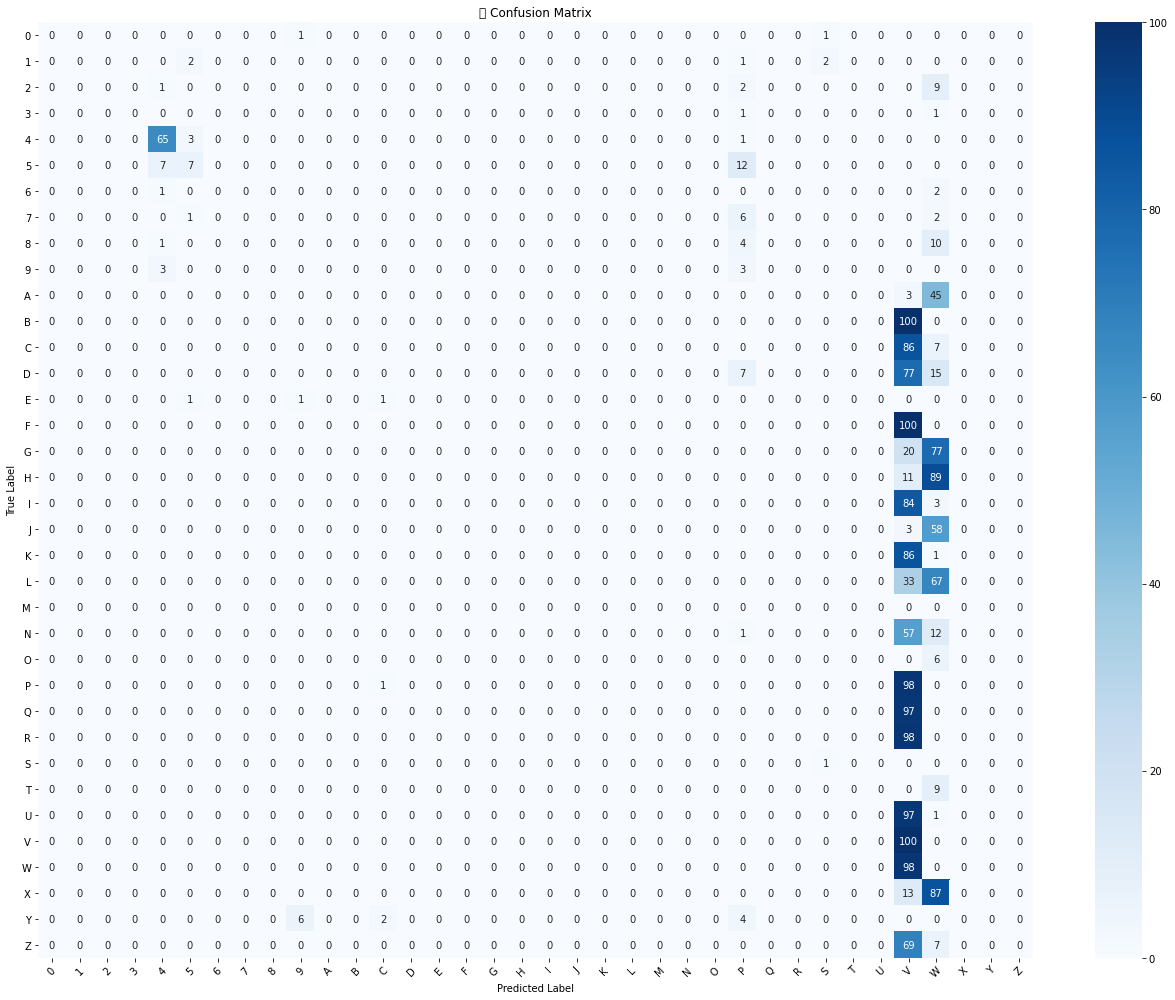


📊 Classification Report:



ValueError: Number of classes, 35, does not match size of target_names, 36. Try specifying the labels parameter

In [24]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp

# --- Config ---
IMG_SIZE = 64
MODEL_PATH = "sign_language_modelv5.h5"
TEST_DATA_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded!")

# --- Load label map ---
class_labels = sorted(os.listdir(TEST_DATA_PATH))
label_to_index = {label: i for i, label in enumerate(class_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

# --- Init MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# --- Helper: Crop hand ---
def extract_hand_region(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        img_h, img_w, _ = image.shape
        x = [lm.x * img_w for lm in hand.landmark]
        y = [lm.y * img_h for lm in hand.landmark]
        x_min, x_max = int(min(x)) - 10, int(max(x)) + 10
        y_min, y_max = int(min(y)) - 10, int(max(y)) + 10
        return image[max(0, y_min):min(img_h, y_max), max(0, x_min):min(img_w, x_max)]
    return None

# --- Prepare Test Data ---
true_labels = []
pred_labels = []

print("\n🔍 Starting prediction on 100 random images per class...")

for label in class_labels:
    folder_path = os.path.join(TEST_DATA_PATH, label)
    if not os.path.isdir(folder_path):
        continue

    images = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    sampled_images = random.sample(images, min(100, len(images)))

    for filename in sampled_images:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        hand_roi = extract_hand_region(image)
        if hand_roi is None:
            continue

        hand_roi = cv2.resize(hand_roi, (IMG_SIZE, IMG_SIZE))
        hand_roi = hand_roi.astype("float32") / 255.0
        hand_roi = np.expand_dims(hand_roi, axis=0)

        prediction = model.predict(hand_roi, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = index_to_label[predicted_index]

        true_labels.append(label)
        pred_labels.append(predicted_label)

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, pred_labels, labels=class_labels)
plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Classification Report ---
print("\n📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

In [6]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import img_to_array
import mediapipe as mp

# Load trained model
model = tf.keras.models.load_model("sign_language_modelv7.h5")
print("✅ Model loaded successfully!")

# Image parameters
IMG_SIZE = 128

# Dataset paths
test_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
class_labels = sorted(os.listdir(test_dataset_path))

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Hand detection and preprocessing
def extract_hand_region(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        img_height, img_width, _ = image.shape
        x_coords = [lm.x * img_width for lm in hand.landmark]
        y_coords = [lm.y * img_height for lm in hand.landmark]
        x_min, x_max = int(min(x_coords)) - 10, int(max(x_coords)) + 10
        y_min, y_max = int(min(y_coords)) - 10, int(max(y_coords)) + 10
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img_width, x_max), min(img_height, y_max)
        return image[y_min:y_max, x_min:x_max]
    return None

# Accuracy counters
correct_per_class = {label: 0 for label in class_labels}
total_per_class = {label: 0 for label in class_labels}

# Loop through each class folder
for label in class_labels:
    folder_path = os.path.join(test_dataset_path, label)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n🔍 Testing class: {label}")

    # Get all image files in the folder
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    selected_images = random.sample(all_images, min(100, len(all_images)))  # Pick 100 or fewer

    for filename in selected_images:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue

        hand_roi = extract_hand_region(image)
        if hand_roi is None:
            continue

        hand_roi = cv2.resize(hand_roi, (IMG_SIZE, IMG_SIZE))
        hand_roi = hand_roi.astype("float32") / 255.0
        hand_roi = np.expand_dims(hand_roi, axis=0)

        prediction = model.predict(hand_roi, verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_label = class_labels[predicted_index]

        if predicted_label == label:
            correct_per_class[label] += 1
        total_per_class[label] += 1

# Print accuracy per class
print("\n📊 Per-Class Accuracy:")
for label in class_labels:
    total = total_per_class[label]
    correct = correct_per_class[label]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label}: {accuracy:.2f}% ({correct}/{total})")
    print(f"Expected: {label}, Predicted: {predicted_label}")

✅ Model loaded successfully!

🔍 Testing class: 0

🔍 Testing class: 1

🔍 Testing class: 2

🔍 Testing class: 3

🔍 Testing class: 4

🔍 Testing class: 5

🔍 Testing class: 6

🔍 Testing class: 7

🔍 Testing class: 8

🔍 Testing class: 9

🔍 Testing class: A

🔍 Testing class: B

🔍 Testing class: C

🔍 Testing class: D

🔍 Testing class: E

🔍 Testing class: F

🔍 Testing class: G

🔍 Testing class: H

🔍 Testing class: I

🔍 Testing class: J

🔍 Testing class: K

🔍 Testing class: L

🔍 Testing class: M

🔍 Testing class: N

🔍 Testing class: O

🔍 Testing class: P

🔍 Testing class: Q

🔍 Testing class: R

🔍 Testing class: S

🔍 Testing class: T

🔍 Testing class: U

🔍 Testing class: V

🔍 Testing class: W

🔍 Testing class: X

🔍 Testing class: Y

🔍 Testing class: Z

📊 Per-Class Accuracy:
0: 100.00% (2/2)
Expected: 0, Predicted: Z
1: 100.00% (2/2)
Expected: 1, Predicted: Z
2: 33.33% (2/6)
Expected: 2, Predicted: Z
3: 0.00% (0/1)
Expected: 3, Predicted: Z
4: 85.94% (55/64)
Expected: 4, Predicted: Z
5: 96.00% (24/2

In [7]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import pyttsx3
import time

# Initialize text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)  # Adjust speech rate

# Load trained model
model = load_model("sign_language_modelv3.h5")

# Define image size for model
IMG_SIZE = 64  

# Initialize Mediapipe Hand Detector
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

# Open webcam
cap = cv2.VideoCapture(0)

# Mapping class indices to letters and numbers
class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z', 26: ' ', 27: '0', 28: '1', 29: '2',
                30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9'}

# Store detected letters
detected_text = []
last_letter = None
last_time = time.time()
confidence_threshold = 0.6  # Adjust threshold for better accuracy

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for Mediapipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect hands
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Get bounding box around hand
            x_min = min([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
            y_min = min([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
            x_max = max([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
            y_max = max([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
            
            # Expand bounding box to avoid cutting fingers
            padding = 20  # Adjust as needed
            x_min = max(x_min - padding, 0)
            y_min = max(y_min - padding, 0)
            x_max = min(x_max + padding, frame.shape[1])
            y_max = min(y_max + padding, frame.shape[0])

            # Crop hand region
            hand_img = frame[y_min:y_max, x_min:x_max]

            if hand_img.size > 0:
                # Convert to grayscale
                hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)

                # Resize to model input
                hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))

                # Expand dims to (64, 64, 1)
                hand_img = np.expand_dims(hand_img, axis=-1)

                # Normalize pixel values
                hand_img = hand_img / 255.0

                # Add batch dimension: (1, 64, 64, 1)
                hand_img = np.expand_dims(hand_img, axis=0)

                # Predict sign
                prediction = model.predict(hand_img)
                if np.max(prediction) > confidence_threshold:
                    predicted_class = np.argmax(prediction)
                    letter = class_labels.get(predicted_class, "?")
                    
                    # Avoid repeating the same letter too frequently
                    current_time = time.time()
                    if letter != last_letter or (current_time - last_time) > 2:
                        detected_text.append(letter)
                        last_letter = letter
                        last_time = current_time

    # Format detected text
    formatted_text = "".join(detected_text).strip()

    # Display text on frame
    cv2.putText(frame, f"Text: {formatted_text}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Convert text to speech when a space is detected
    if detected_text and detected_text[-1] == " ":
        final_text = formatted_text.strip()
        if final_text:
            print("\n🗣 Speaking:", final_text)
            engine.say(final_text)
            engine.runAndWait()
            detected_text = []  # Clear after speaking

    # Show the frame
    cv2.imshow("Sign Language Recognition", frame)

    # Keyboard controls:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Quit program
        break
    elif key == ord('c'):  # Clear text
        detected_text = []
        print("\n🟢 Text cleared! Start again.\n")

# Speak final text before exiting
if detected_text:
    final_text = "".join(detected_text).strip()
    print("\nFinal Deciphered Text:", final_text)
    engine.say(final_text)
    engine.runAndWait()

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step

🟢 Text cleared! Start again.

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step

🟢 Text cleared! Start again.



In [5]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("sign_language_modelv7.h5")

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 36)                9252      
                                                                 
Total params: 2595172 (9.90 MB)
Trainable params: 186358

In [9]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pickle

# --- Config ---
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"  # folder with test images
MODEL_PATH = "sign_language_modelv7.h5"
LABEL_MAP_PATH = "label_map.pkl"
IMG_SIZE = 128  # Assuming MobileNetV2 input size
BATCH_SIZE = 1

# --- Load label map ---
with open(LABEL_MAP_PATH, 'rb') as f:
    label_map = pickle.load(f)
inv_label_map = {v: k for k, v in label_map.items()}

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Helper: preprocess image ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Run prediction ---
def predict_on_folder(folder_path):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')): continue

        # Get expected label from filename (e.g., "A_001.jpg" => "A")
        expected = img_name.split("_")[0]

        # Preprocess and predict
        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor)
        pred_index = np.argmax(preds[0])
        predicted_label = label_map[pred_index]

        # Print result
        print(f"🖼️ Image: {img_name}")
        print(f"✅ Expected: {expected} | 🔮 Predicted: {predicted_label}")
        print("-" * 40)

        # Optional: Show image with prediction
        # img_show = image.load_img(img_path)
        # plt.imshow(img_show)
        # plt.title(f"Expected: {expected} | Predicted: {predicted_label}")
        # plt.axis("off")
        # plt.show()

# --- Run it ---
predict_on_folder(TEST_DIR)

1/1 [==============================] - 1s 801ms/step
🖼️ Image: 0_test.jpg
✅ Expected: 0 | 🔮 Predicted: 0.0
----------------------------------------
1/1 [==============================] - 0s 57ms/step
🖼️ Image: 1_test.jpg
✅ Expected: 1 | 🔮 Predicted: 1.0
----------------------------------------
1/1 [==============================] - 0s 56ms/step


KeyError: 2

In [11]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv7.h5"
CLASS_NAMES_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names ---
with open(CLASS_NAMES_PATH, "r") as f:
    class_names = [line.strip() for line in f]

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming this is how labels are encoded

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label == predicted_label
        correct += is_correct
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct/total)*100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: S | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: E | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: O | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 4 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: G | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅

In [24]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv8.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 4 | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: S | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: E | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: O | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 4 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: 9 | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: 6 | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅ E

In [22]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import json

# --- Config ---
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
MODEL_PATH = "sign_language_modelv8.h5"
LABEL_MAP_PATH = "model_label_map.json"
IMG_SIZE = 128

# --- Load label map ---
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)
inv_label_map = {int(v): k for k, v in label_map.items()}  # convert values to int keys

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Helper: preprocess image ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Run prediction ---
def predict_on_folder(folder_path):
    total = 0
    correct = 0

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        expected_label = img_name.split("_")[0]

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = int(np.argmax(preds[0]))
        predicted_label = inv_label_map.get(pred_index, "Unknown")

        # Ensure both labels are compared as strings
        is_correct = (str(predicted_label).upper() == str(expected_label).upper())
        total += 1
        if is_correct:
            correct += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run it ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 4 | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: s | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: e | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: c | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: o | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: e | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 4 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: 9 | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: 6 | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: i | ✔️
🖼️ J_test.jpg | ✅ E

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ========== CONFIG ==========
dataset_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"# adjust this to your actual dataset path
train_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
test_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"

img_size = (128, 128)
batch_size = 32
epochs = 30

# ========== DATA GENERATORS ==========
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Custom generator for testing images with filenames
def test_generator_from_directory(test_dir, batch_size=1):
    filenames = os.listdir(test_dir)
    filenames.sort()  # Optional: Ensure alphabetical order of filenames
    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image = load_img(os.path.join(test_dir, filename), target_size=img_size)
            image = img_to_array(image) / 255.0
            label = filename.split('_')[0]  # Assuming the filename format is like A_1.jpg
            yield image, label

test_generator = test_generator_from_directory(test_dir, batch_size)

# Create label map (indices to class names)
label_map = {v: k for k, v in train_generator.class_indices.items()}

# ========== MODEL BUILDING ==========
base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ========== CALLBACKS ==========
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("mobilenetv2_signlang.h5", save_best_only=True, verbose=1)
]

# ========== TRAINING ==========
start = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)
print(f"\n✅ Training complete in {(time.time() - start)/60:.2f} minutes.")

# ========== EVALUATION ON TEST SET ==========
y_true = []
y_pred = []

# Iterate through the test generator
for image, label in test_generator:
    y_true.append(label)
    y_pred_probs = model.predict(np.expand_dims(image, axis=0), verbose=1)
    y_pred.append(np.argmax(y_pred_probs, axis=1)[0])

# Convert to numpy arrays for metrics
y_true = np.array([label_map.get(label, label) for label in y_true])  # Map labels to class names
y_pred = np.array([label_map.get(str(class_id), str(class_id)) for class_id in y_pred])

# ========== CLASSIFICATION REPORT & CONFUSION MATRIX ==========
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

conf_matrix = confusion_matrix(y_true, y_pred)

# ========== PLOTS ==========
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)
plot_confusion_matrix(conf_matrix, list(train_generator.class_indices.keys()))

Found 65828 images belonging to 37 classes.
Found 16456 images belonging to 37 classes.
Epoch 1/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9896
Epoch 1: val_loss improved from inf to 0.01054, saving model to mobilenetv2_signlang.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2058/2058 [==============================] - 1728s 833ms/step - loss: 0.0433 - accuracy: 0.9896 - val_loss: 0.0105 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 2/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975
Epoch 2: val_loss improved from 0.01054 to 0.00182, saving model to mobilenetv2_signlang.h5
2058/2058 [==============================] - 1764s 857ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0018 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 3/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9982
Epoch 3: val_loss did not improve from 0.00182
2058/2058 [==============================] - 1727s 839ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0045 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 4/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve fro

ValueError: Number of classes, 38, does not match size of target_names, 37. Try specifying the labels parameter

Found 65828 images belonging to 37 classes.
Found 16456 images belonging to 37 classes.
Epoch 1/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9769
Epoch 1: val_loss improved from inf to 0.02035, saving model to mobilenetv2_asl_model.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2058/2058 [==============================] - 1018s 492ms/step - loss: 0.0815 - accuracy: 0.9769 - val_loss: 0.0204 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 2/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9919
Epoch 2: val_loss improved from 0.02035 to 0.01470, saving model to mobilenetv2_asl_model.h5
2058/2058 [==============================] - 1022s 497ms/step - loss: 0.0240 - accuracy: 0.9919 - val_loss: 0.0147 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 3/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9933
Epoch 3: val_loss did not improve from 0.01470
2058/2058 [==============================] - 1001s 486ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0152 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 4/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9950
Epoch 4: val_loss improved from 0.01470 to 0.01205, saving model to mobilenetv2_asl_model.h5
2058/2058 [=========

C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


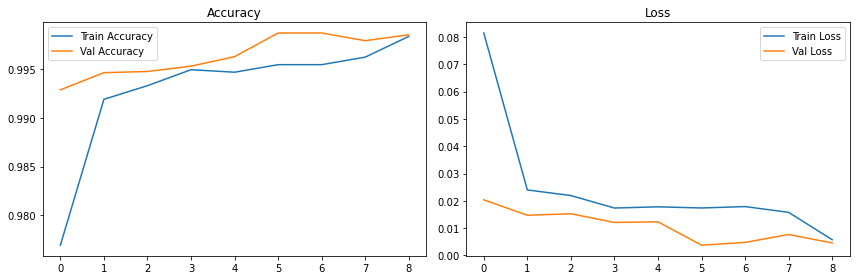

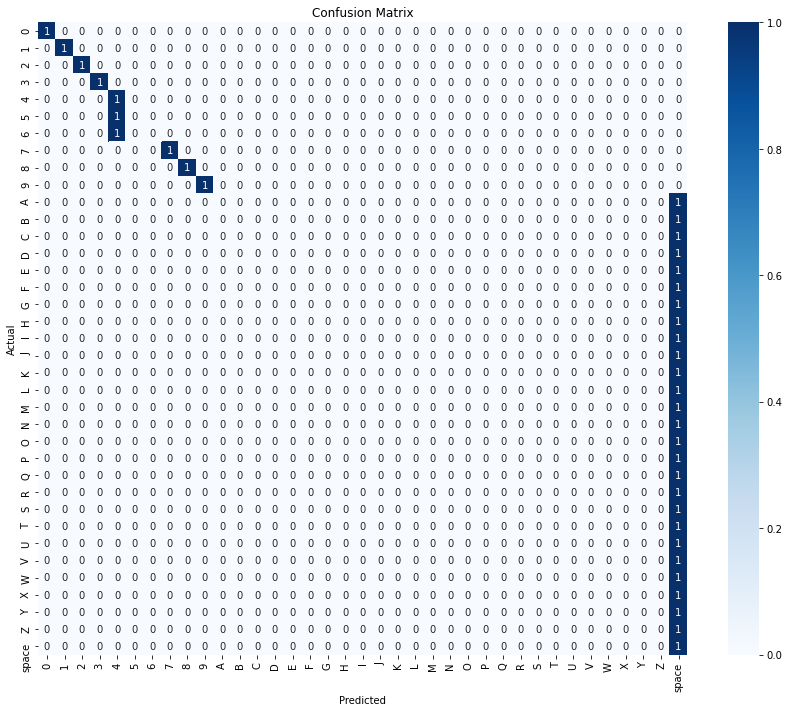

In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# ========== PATHS ==========
train_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
test_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
img_size = (128, 128)
batch_size = 32
epochs = 30

# ========== DATA GENERATORS ==========
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ========== LABEL MAP ==========
label_map = train_generator.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== MODEL ==========
base_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========== CALLBACKS ==========
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("mobilenetv2_asl_model.h5", save_best_only=True, verbose=1)
]

# ========== TRAINING ==========
start = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Model trained in {(time.time()-start)/60:.2f} minutes.")

# ========== UNSEEN TEST SET EVALUATION ==========
def load_test_images(test_dir, target_size):
    images = []
    labels = []
    filenames = os.listdir(test_dir)
    for fname in filenames:
        if fname.endswith((".jpg", ".png", ".jpeg")):
            label = fname.split("_")[0]  # assumes label is before underscore
            img = Image.open(os.path.join(test_dir, fname)).convert("RGB")
            img = img.resize(target_size)
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), labels

X_test, y_true = load_test_images(test_dir, img_size)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Label encode y_true using training classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(list(label_map.keys()))
y_true_encoded = label_encoder.transform(y_true)

# ========== CLASSIFICATION REPORT & CONFUSION MATRIX ==========
print("\n=== Classification Report ===")
print(classification_report(y_true_encoded, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_true_encoded, y_pred)

# ========== PLOTS ==========
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)
plot_confusion_matrix(conf_matrix, classes=label_encoder.classes_)

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# ========== PATHS ==========
train_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
test_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
img_size = (128, 128)
batch_size = 32
epochs = 30

# ========== DATA GENERATORS ==========
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ========== LABEL MAP ==========
label_map = train_generator.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== MODEL ==========
base_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========== CALLBACKS ==========
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("mobilenetv2_asl_model.h5", save_best_only=True, verbose=1)
]

# ========== INITIAL TRAINING ==========
start = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Model trained in {(time.time()-start)/60:.2f} minutes.")

# ========== FINE-TUNING ==========
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("mobilenetv2_asl_finetuned.h5", save_best_only=True, verbose=1)
]

start_fine = time.time()
fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=fine_callbacks
)
print(f"✅ Fine-tuned in {(time.time()-start_fine)/60:.2f} minutes.")

# ========== UNSEEN TEST SET EVALUATION ==========
def load_test_images(test_dir, target_size):
    images = []
    labels = []
    filenames = os.listdir(test_dir)
    for fname in filenames:
        if fname.endswith((".jpg", ".png", ".jpeg")):
            label = fname.split("_")[0]
            img = Image.open(os.path.join(test_dir, fname)).convert("RGB")
            img = img.resize(target_size)
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), labels

X_test, y_true = load_test_images(test_dir, img_size)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(list(label_map.keys()))
y_true_encoded = label_encoder.transform(y_true)

# ========== CLASSIFICATION REPORT ==========
print("\n=== Classification Report ===")
print(classification_report(y_true_encoded, y_pred, target_names=label_encoder.classes_))

# ========== CONFUSION MATRIX ==========
conf_matrix = confusion_matrix(y_true_encoded, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history, title='Initial Training')
plot_learning_curve(fine_history, title='Fine-Tuning')
plot_confusion_matrix(conf_matrix, classes=label_encoder.classes_)

Found 65828 images belonging to 37 classes.
Found 16456 images belonging to 37 classes.
Epoch 1/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9759
Epoch 1: val_loss improved from inf to 0.01324, saving model to mobilenetv2_asl_model.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2058/2058 [==============================] - 936s 453ms/step - loss: 0.0856 - accuracy: 0.9759 - val_loss: 0.0132 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 2/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9923
Epoch 2: val_loss improved from 0.01324 to 0.00803, saving model to mobilenetv2_asl_model.h5
2058/2058 [==============================] - 1050s 510ms/step - loss: 0.0228 - accuracy: 0.9923 - val_loss: 0.0080 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 3/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9931
Epoch 3: val_loss did not improve from 0.00803
2058/2058 [==============================] - 1243s 604ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0101 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 4/30
2058/2058 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9949
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve fro

KeyboardInterrupt: 

🔍 Total images found: 794935
📁 Copying training images...
📁 Copying validation images...
Found 64000 images belonging to 37 classes.
Found 16000 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Starting training on sampled unseen data...
Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 3.0316 - accuracy: 0.2844
Epoch 1: val_loss improved from inf to 1.85284, saving model to mobilenetv2_asl_extended.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 1101s 549ms/step - loss: 3.0316 - accuracy: 0.2844 - val_loss: 1.8528 - val_accuracy: 0.4741 - lr: 1.2500e-04
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 1.8114 - accuracy: 0.4629
Epoch 2: val_loss improved from 1.85284 to 1.42197, saving model to mobilenetv2_asl_extended.h5
2000/2000 [==============================] - 1087s 544ms/step - loss: 1.8114 - accuracy: 0.4629 - val_loss: 1.4220 - val_accuracy: 0.5874 - lr: 1.2500e-04
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 1.4742 - accuracy: 0.5554
Epoch 3: val_loss improved from 1.42197 to 1.19115, saving model to mobilenetv2_asl_extended.h5
2000/2000 [==============================] - 1271s 636ms/step - loss: 1.4742 - accuracy: 0.5554 - val_loss: 1.1911 - val_accuracy: 0.6543 - lr: 1.2500e-04
Epoch 4/10
2000/2000 [==============================] - ETA: 0s - loss: 1.2620 - accuracy: 0.6151
Epoch 4: val_loss improved from 1.19115 to 1.0325

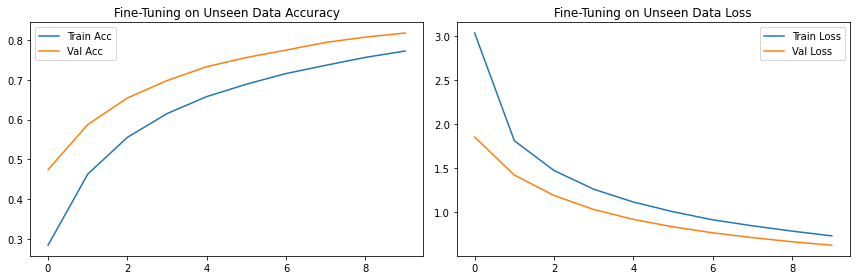

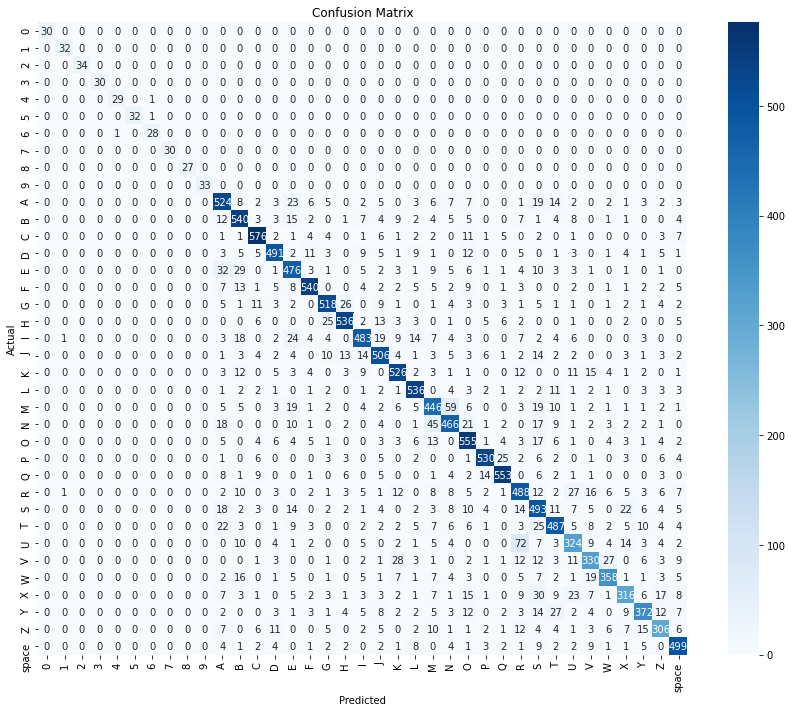

In [3]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from pathlib import Path

# ========== CONFIGURATION ==========
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Split dataset/"
sample_size = 80000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 10
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random 80K Images ==========
all_image_paths = []
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_image_paths.append(os.path.join(class_path, fname))

print(f"🔍 Total images found: {len(all_image_paths)}")
sampled_images = random.sample(all_image_paths, min(sample_size, len(all_image_paths)))

train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))

print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Sampled Data ==========
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ==========
# Load your previously trained model or start fresh with MobileNetV2 base
try:
    print("🔄 Loading existing model...")
    model = load_model("mobilenetv2_asl_model.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# ========== STEP 4: Train on Unseen Data ==========
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("mobilenetv2_asl_extended.h5", save_best_only=True, verbose=1)
]

print("🚀 Starting training on sampled unseen data...")
start = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
print(f"✅ Training completed in {(time.time()-start)/60:.2f} minutes.")

# ========== STEP 5: Evaluate Model ==========
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history, title='Fine-Tuning on Unseen Data')
plot_confusion_matrix(conf_matrix, classes=class_labels)

In [5]:
# ===============================
# Focused Fine-Tuning Script (Auto Dataset) - Full Upgraded Version
# ===============================

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import shutil
import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configs ---
base_model_path = 'mobilenetv2_asl_extended.h5'
original_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
focused_dataset_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Focused dataset/"
confused_labels = ['0', '2', '3', '6', 'R', 'X', 'Y']
samples_per_class = 300
image_size = (224, 224)
batch_size = 32
epochs = 10
model_save_path = 'sign_language_modelv14.h5'
report_folder = 'training_reports'

# --- Step 1: Prepare Focused Dataset Automatically
def prepare_focused_dataset():
    print("🛠️ Preparing focused dataset...")
    
    if os.path.exists(focused_dataset_path):
        shutil.rmtree(focused_dataset_path)
    os.makedirs(focused_dataset_path)

    for label in confused_labels:
        source_dir = os.path.join(original_dataset_path, label)
        target_dir = os.path.join(focused_dataset_path, label)
        os.makedirs(target_dir, exist_ok=True)

        all_images = os.listdir(source_dir)
        selected_images = random.sample(all_images, min(samples_per_class, len(all_images)))

        for img_name in selected_images:
            src_img_path = os.path.join(source_dir, img_name)
            dst_img_path = os.path.join(target_dir, img_name)
            shutil.copy(src_img_path, dst_img_path)
    
    print(f"✅ Focused dataset prepared at '{focused_dataset_path}'.")

prepare_focused_dataset()

# --- Step 2: Load the base model
print("✅ Loading base model...")
base_model = load_model(base_model_path)

# --- Step 3: Modify model output for 7 classes
print("✅ Modifying model output layer for 7 classes...")
x = base_model.layers[-2].output
new_output = Dense(len(confused_labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=new_output)

# --- Step 4: Freeze all layers except the last few
for layer in model.layers[:-10]:
    layer.trainable = False
print("✅ Frozen all layers except last few.")

# --- Step 5: Setup Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

train_generator = train_datagen.flow_from_directory(
    focused_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    focused_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Step 6: Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Model compiled for fine-tuning.")

# --- Step 7: Fine-tune the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

# --- Step 8: Save the fine-tuned model
model.save(model_save_path)
print(f"✅ Fine-tuned model saved as '{model_save_path}'.")

# --- Step 9: Auto-generate Confusion Matrix and Classification Report
print("📈 Generating confusion matrix and classification report...")

# Create report folder
if not os.path.exists(report_folder):
    os.makedirs(report_folder)

# Get predictions
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'confusion_matrix.png'))
plt.close()
print("✅ Confusion matrix saved.")

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
with open(os.path.join(report_folder, 'classification_report.txt'), 'w') as f:
    f.write(report)
print("✅ Classification report saved.")

print("\n🎯 Fine-tuning completed successfully with evaluation reports generated!")

🛠️ Preparing focused dataset...
✅ Focused dataset prepared at 'C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Focused dataset/'.
✅ Loading base model...
✅ Modifying model output layer for 7 classes...
✅ Frozen all layers except last few.
Found 1890 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
✅ Model compiled for fine-tuning.
Epoch 1/10
60/60 [==============================] - 70s 1s/step - loss: 1.7605 - accuracy: 0.3095 - val_loss: 1.3815 - val_accuracy: 0.5857
Epoch 2/10
60/60 [==============================] - 75s 1s/step - loss: 1.2043 - accuracy: 0.5688 - val_loss: 1.0790 - val_accuracy: 0.6571
Epoch 3/10
60/60 [==============================] - 75s 1s/step - loss: 0.9527 - accuracy: 0.6545 - val_loss: 0.8730 - val_accuracy: 0.7381
Epoch 4/10
60/60 [==============================] - 76s 1s/step - loss: 0.8053 - accuracy: 0.7048 - val_loss: 0.7556 - val_accuracy: 0.7619
Epoch 5/10
60/60 [===============

C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Fine-tuned model saved as 'sign_language_modelv14.h5'.
📈 Generating confusion matrix and classification report...
7/7 [==============================] - 8s 953ms/step
✅ Confusion matrix saved.
✅ Classification report saved.

🎯 Fine-tuning completed successfully with evaluation reports generated!


🔍 Total images found: 794935
📁 Copying training images...
📁 Copying validation images...
Found 64000 images belonging to 37 classes.
Found 16000 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Phase 1: Training top layers...
Epoch 1/5
2000/2000 [==============================] - ETA: 0s - loss: 1.6026 - accuracy: 0.5180
Epoch 1: val_loss improved from inf to 0.75982, saving model to sign_language_modelv15_phase1.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 1499s 745ms/step - loss: 1.6026 - accuracy: 0.5180 - val_loss: 0.7598 - val_accuracy: 0.7714 - lr: 1.2500e-04
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 1.4233 - accuracy: 0.5607
Epoch 2: val_loss improved from 0.75982 to 0.75299, saving model to sign_language_modelv15_phase1.h5
2000/2000 [==============================] - 1133s 567ms/step - loss: 1.4233 - accuracy: 0.5607 - val_loss: 0.7530 - val_accuracy: 0.7728 - lr: 1.2500e-04
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.5848
Epoch 3: val_loss improved from 0.75299 to 0.73855, saving model to sign_language_modelv15_phase1.h5
2000/2000 [==============================] - 1006s 503ms/step - loss: 1.3312 - accuracy: 0.5848 - val_loss: 0.7385 - val_accuracy: 0.7778 - lr: 1.2500e-04
Epoch 4/5
2000/2000 [==============================] - ETA: 0s - loss: 1.2713 - accuracy: 0.6045
Epoch 4: val_loss improved from 0.73855 to

2000/2000 [==============================] - 1421s 711ms/step - loss: 1.1256 - accuracy: 0.8903 - val_loss: 1.0188 - val_accuracy: 0.9220 - lr: 1.0000e-05
Epoch 20/20
2000/2000 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.8966
Epoch 20: val_loss improved from 1.01881 to 1.00191, saving model to sign_language_modelv15_phase2.h5
2000/2000 [==============================] - 1422s 711ms/step - loss: 1.1070 - accuracy: 0.8966 - val_loss: 1.0019 - val_accuracy: 0.9259 - lr: 1.0000e-05
✅ Fine-tuning completed in 452.04 minutes.
500/500 [==============================] - 181s 361ms/step

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        29
           5       1.00      1.

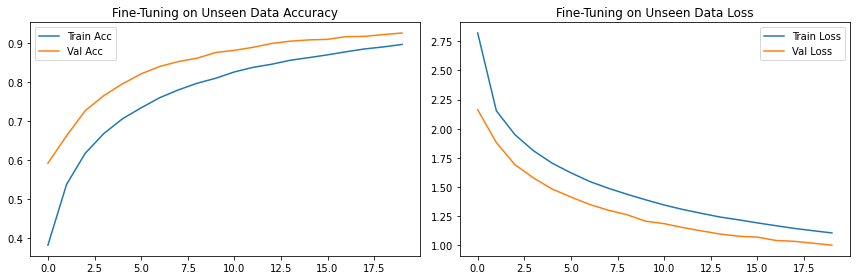

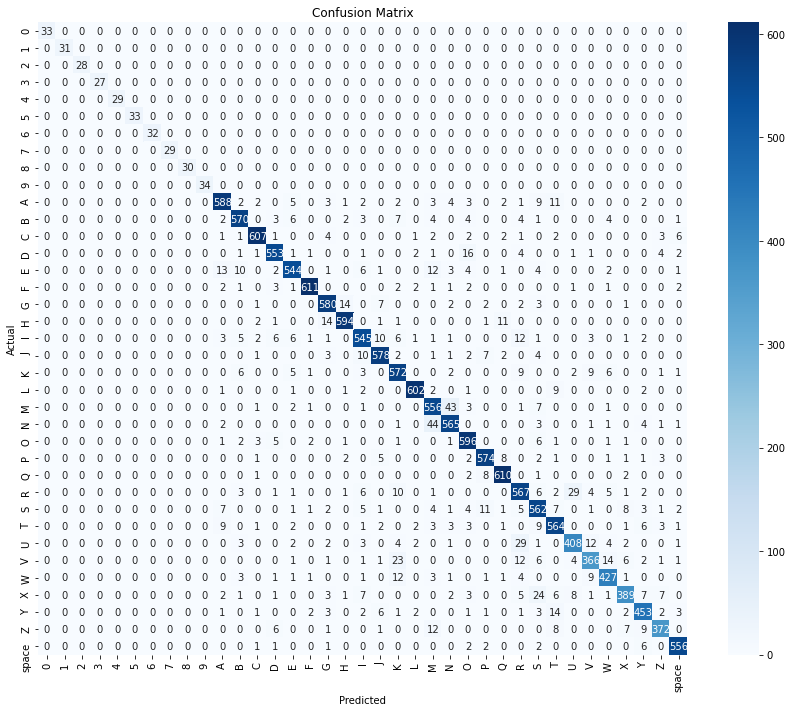

In [8]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ========== CONFIGURATION ==========
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Split dataset 1/"
sample_size = 80000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 20
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random Images ==========
all_image_paths = []
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_image_paths.append(os.path.join(class_path, fname))

print(f"🔍 Total images found: {len(all_image_paths)}")
sampled_images = random.sample(all_image_paths, min(sample_size, len(all_image_paths)))

train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

if os.path.exists(temp_dataset):
    shutil.rmtree(temp_dataset)
os.makedirs(os.path.join(temp_dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(temp_dataset, "val"), exist_ok=True)

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))
print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Data ==========
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ==========
try:
    print("🔄 Loading existing model...")
    model = load_model("mobilenetv2_asl_extended.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

# ========== STEP 4: Fine-tuning ==========
# Phase 1 - Train top layers only
print("🚀 Phase 1: Training top layers...")
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv15_phase1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks_phase1
)

# Phase 2 - Unfreeze last 50 layers + continue training
print("🔓 Phase 2: Fine-tuning last 50 layers...")
for layer in model.layers[0].layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv15_phase2.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

print("🚀 Phase 2: Fine-tuning full model...")
start = time.time()
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks_phase2
)
print(f"✅ Fine-tuning completed in {(time.time()-start)/60:.2f} minutes.")

# ========== STEP 5: Evaluate ==========
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history_phase2, title='Fine-Tuning on Unseen Data')
plot_confusion_matrix(conf_matrix, classes=class_labels)

🔍 Total images found: 82320
📁 Copying training images...
📁 Copying validation images...
Found 8000 images belonging to 37 classes.
Found 2000 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Phase 1: Training top layers...
Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 1.1861 - accuracy: 0.8789
Epoch 1: val_loss improved from inf to 1.02172, saving model to sign_language_modelv18_phase1.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 222s 864ms/step - loss: 1.1861 - accuracy: 0.8789 - val_loss: 1.0217 - val_accuracy: 0.9305 - lr: 1.0000e-05
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.9567
Epoch 2: val_loss improved from 1.02172 to 0.94288, saving model to sign_language_modelv18_phase1.h5
250/250 [==============================] - 246s 986ms/step - loss: 0.9824 - accuracy: 0.9567 - val_loss: 0.9429 - val_accuracy: 0.9575 - lr: 1.0000e-05
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.9332 - accuracy: 0.9735
Epoch 3: val_loss improved from 0.94288 to 0.88859, saving model to sign_language_modelv18_phase1.h5
250/250 [==============================] - 230s 919ms/step - loss: 0.9332 - accuracy: 0.9735 - val_loss: 0.8886 - val_accuracy: 0.9805 - lr: 1.0000e-05
Epoch 4/5
250/250 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.9812
Epoch 4: val_loss improved from 0.88859 to 0.86474, savin

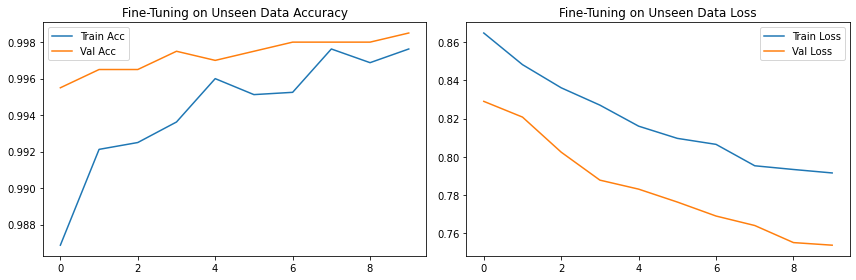

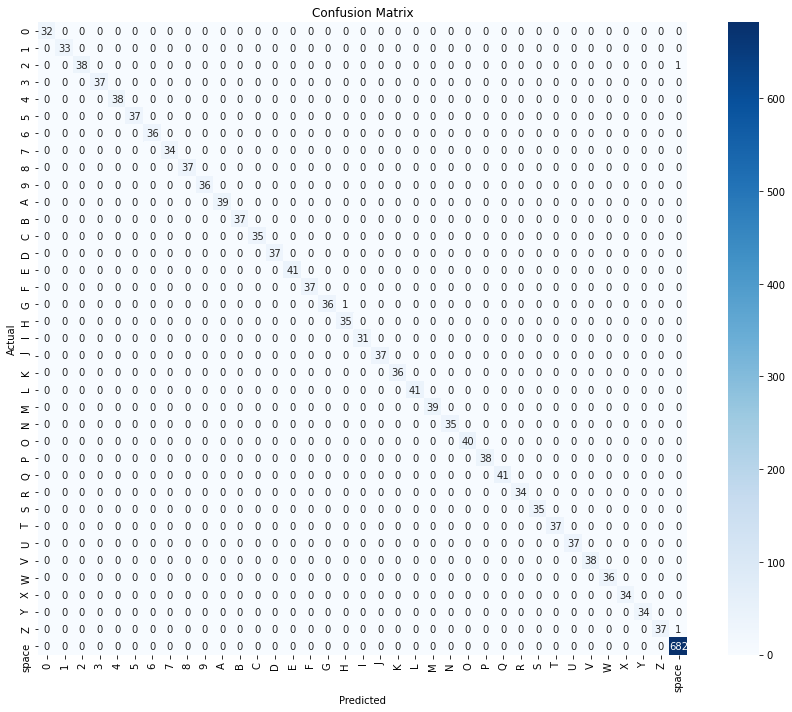

In [6]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ========== CONFIGURATION ==========
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Pre-Processed Data/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Split dataset 1/"
sample_size = 10000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 10
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random Images ==========
all_image_paths = []
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_image_paths.append(os.path.join(class_path, fname))

print(f"🔍 Total images found: {len(all_image_paths)}")
sampled_images = random.sample(all_image_paths, min(sample_size, len(all_image_paths)))

train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

if os.path.exists(temp_dataset):
    shutil.rmtree(temp_dataset)
os.makedirs(os.path.join(temp_dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(temp_dataset, "val"), exist_ok=True)

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))
print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Data ==========
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ==========
try:
    print("🔄 Loading existing model...")
    model = load_model("sign_language_modelv15_phase2.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

# ========== STEP 4: Fine-tuning ==========
# Phase 1 - Train top layers only
print("🚀 Phase 1: Training top layers...")
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv18_phase1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks_phase1
)

# Phase 2 - Unfreeze last 50 layers + continue training
print("🔓 Phase 2: Fine-tuning last 50 layers...")
for layer in model.layers[0].layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv18_phase2.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

print("🚀 Phase 2: Fine-tuning full model...")
start = time.time()
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks_phase2
)
print(f"✅ Fine-tuning completed in {(time.time()-start)/60:.2f} minutes.")

# ========== STEP 5: Evaluate ==========
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history_phase2, title='Fine-Tuning on Unseen Data')
plot_confusion_matrix(conf_matrix, classes=class_labels)

🔍 Total images found: 228208
📁 Copying training images...
📁 Copying validation images...
Found 16000 images belonging to 37 classes.
Found 4000 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Phase 1: Training top layers...
Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.1184 - accuracy: 0.9013
Epoch 1: val_loss improved from inf to 0.94878, saving model to sign_language_modelv19_phase1.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 364s 716ms/step - loss: 1.1184 - accuracy: 0.9013 - val_loss: 0.9488 - val_accuracy: 0.9452 - lr: 1.0000e-05
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 1.0339 - accuracy: 0.9294
Epoch 2: val_loss improved from 0.94878 to 0.90620, saving model to sign_language_modelv19_phase1.h5
500/500 [==============================] - 382s 764ms/step - loss: 1.0339 - accuracy: 0.9294 - val_loss: 0.9062 - val_accuracy: 0.9590 - lr: 1.0000e-05
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.9988 - accuracy: 0.9402
Epoch 3: val_loss improved from 0.90620 to 0.88371, saving model to sign_language_modelv19_phase1.h5
500/500 [==============================] - 380s 760ms/step - loss: 0.9988 - accuracy: 0.9402 - val_loss: 0.8837 - val_accuracy: 0.9657 - lr: 1.0000e-05
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.9469
Epoch 4: val_loss improved from 0.88371 to 0.87016, sa

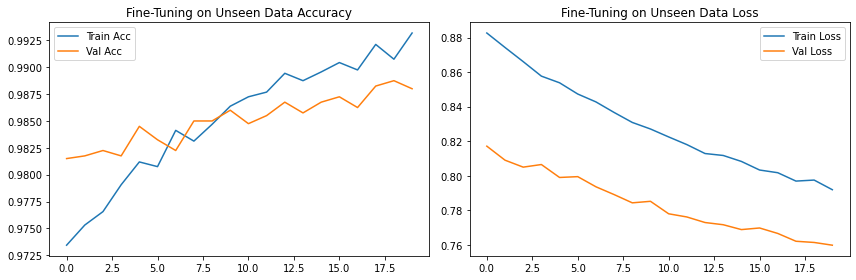

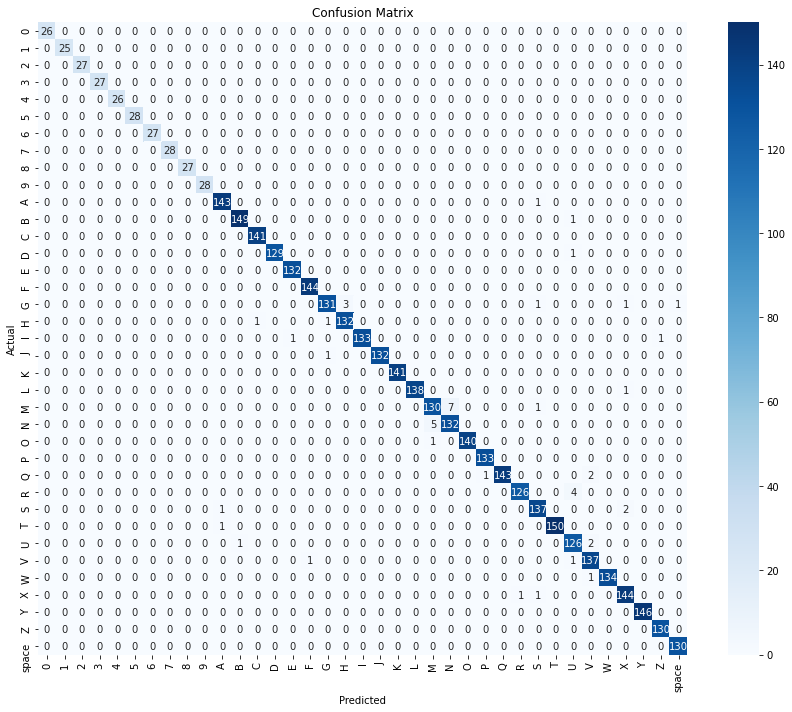

In [7]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ========== CONFIGURATION ==========
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Split dataset/"
sample_size = 20000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 20
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random Images ==========
all_image_paths = []
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_image_paths.append(os.path.join(class_path, fname))

print(f"🔍 Total images found: {len(all_image_paths)}")
sampled_images = random.sample(all_image_paths, min(sample_size, len(all_image_paths)))

train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

if os.path.exists(temp_dataset):
    shutil.rmtree(temp_dataset)
os.makedirs(os.path.join(temp_dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(temp_dataset, "val"), exist_ok=True)

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))
print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Data ==========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],   # simulate bright and dark lighting
    channel_shift_range=20.0,      # slight color variations (background, skin tone)
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ==========
try:
    print("🔄 Loading existing model...")
    model = load_model("sign_language_modelv18_phase1.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

# ========== STEP 4: Fine-tuning ==========
# Phase 1 - Train top layers only
print("🚀 Phase 1: Training top layers...")
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv19_phase1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks_phase1
)

# Phase 2 - Unfreeze last 50 layers + continue training
print("🔓 Phase 2: Fine-tuning last 50 layers...")
for layer in model.layers[0].layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv19_phase2.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

print("🚀 Phase 2: Fine-tuning full model...")
start = time.time()
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks_phase2
)
print(f"✅ Fine-tuning completed in {(time.time()-start)/60:.2f} minutes.")

# ========== STEP 5: Evaluate ==========
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history_phase2, title='Fine-Tuning on Unseen Data')
plot_confusion_matrix(conf_matrix, classes=class_labels)

🔍 Total classes found: 37
📁 Copying training images...
📁 Copying validation images...
Found 3649 images belonging to 37 classes.
Found 1001 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Phase 1: Training top layers...
Epoch 1/10
115/115 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.9375
Epoch 1: val_loss improved from inf to 0.75304, saving model to sign_language_modelv20_phase1.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 64s 510ms/step - loss: 1.0425 - accuracy: 0.9375 - val_loss: 0.7530 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.9978
Epoch 2: val_loss improved from 0.75304 to 0.75009, saving model to sign_language_modelv20_phase1.h5
115/115 [==============================] - 72s 628ms/step - loss: 0.8425 - accuracy: 0.9978 - val_loss: 0.7501 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.9967
Epoch 3: val_loss improved from 0.75009 to 0.74846, saving model to sign_language_modelv20_phase1.h5
115/115 [==============================] - 82s 714ms/step - loss: 0.8217 - accuracy: 0.9967 - val_loss: 0.7485 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/10
115/115 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.9975
Epoch 4: val_loss improved from 0.74846 to 0.73990, savin

Epoch 16/20
115/115 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.9997
Epoch 16: val_loss did not improve from 0.69864
115/115 [==============================] - 90s 786ms/step - loss: 0.7368 - accuracy: 0.9997 - val_loss: 0.6987 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 17/20
115/115 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.9997
Epoch 17: val_loss improved from 0.69864 to 0.69816, saving model to sign_language_modelv20_phase2.h5
115/115 [==============================] - 92s 798ms/step - loss: 0.7363 - accuracy: 0.9997 - val_loss: 0.6982 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 18/20
115/115 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.9997
Epoch 18: val_loss did not improve from 0.69816
115/115 [==============================] - 92s 801ms/step - loss: 0.7370 - accuracy: 0.9997 - val_loss: 0.6996 - val_accuracy: 0.9990 - lr: 1.0000e-05
Epoch 19/20
115/115 [==============================] - ETA

C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\onkar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


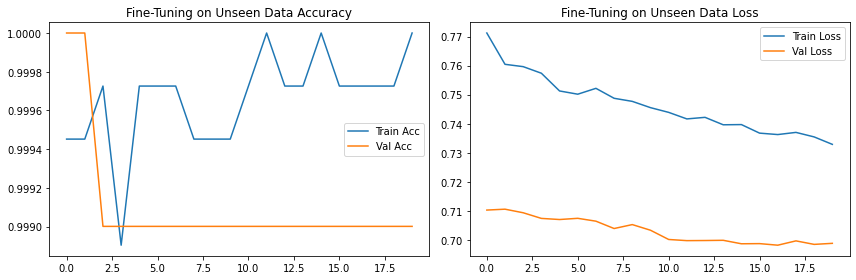

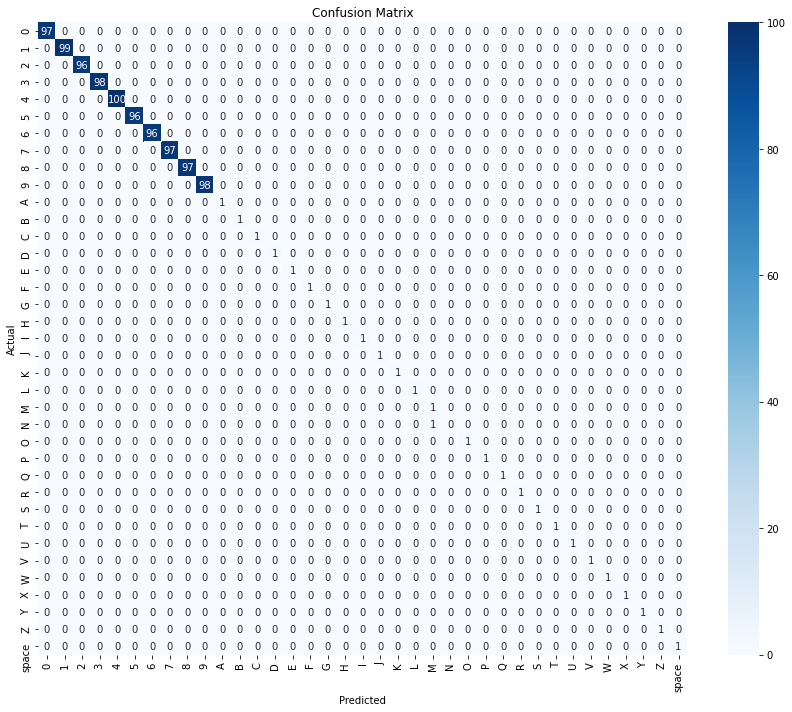

In [1]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ========== CONFIGURATION ========== #
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Split dataset/"
sample_size = 20000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 20
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random Images (Modified) ==========
all_class_images = {}

# Organize all images class-wise
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        all_class_images[class_folder] = []
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_class_images[class_folder].append(os.path.join(class_path, fname))

print(f"🔍 Total classes found: {len(all_class_images)}")

sampled_images = []

# Oversample 0-9 and undersample A-Z + space
for class_name, image_paths in all_class_images.items():
    if class_name in [str(i) for i in range(10)]:  # Class is 0–9 (Digits)
        selected = random.choices(image_paths, k=500)  # Oversample with replacement if needed
    else:  # Class is A–Z and space
        selected = random.sample(image_paths, k=min(5, len(image_paths)))  # Only 5 images max
    sampled_images.extend(selected)

# Now shuffle sampled images
random.shuffle(sampled_images)

# Split into train and val
train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

# Clean and create folders
if os.path.exists(temp_dataset):
    shutil.rmtree(temp_dataset)
os.makedirs(os.path.join(temp_dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(temp_dataset, "val"), exist_ok=True)

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))
print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Data ========== #
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],   # simulate bright and dark lighting
    channel_shift_range=20.0,      # slight color variations (background, skin tone)
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Modified flow to have more frequent digits in each batch
train_gen = train_datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ========== #
try:
    print("🔄 Loading existing model...")
    model = load_model("sign_language_modelv19_phase2.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

# ========== STEP 4: Fine-tuning ========== #
# Phase 1 - Train top layers only
print("🚀 Phase 1: Training top layers...")
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv20_phase1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks_phase1
)

# Phase 2 - Unfreeze last 50 layers + continue training
print("🔓 Phase 2: Fine-tuning last 50 layers...")
for layer in model.layers[0].layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv20_phase2.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

print("🚀 Phase 2: Fine-tuning full model...")
start = time.time()
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks_phase2
)
print(f"✅ Fine-tuning completed in {(time.time()-start)/60:.2f} minutes.")

# ========== STEP 5: Evaluate ========== #
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history_phase2, title='Fine-Tuning on Unseen Data')
plot_confusion_matrix(conf_matrix, classes=class_labels)

In [ ]:
import os
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# ========== CONFIGURATION ========== #
original_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
temp_dataset = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/Split dataset/"
sample_size = 80000
train_split = 0.8
img_size = (128, 128)
batch_size = 32
epochs = 20
img_extensions = ('.jpg', '.jpeg', '.png')

# ========== STEP 1: Sample Random Images (Modified) ==========
all_class_images = {}

# Organize all images class-wise
for class_folder in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_folder)
    if os.path.isdir(class_path):
        all_class_images[class_folder] = []
        for fname in os.listdir(class_path):
            if fname.lower().endswith(img_extensions):
                all_class_images[class_folder].append(os.path.join(class_path, fname))

print(f"🔍 Total classes found: {len(all_class_images)}")

sampled_images = []

# Oversample 0-9 and undersample A-Z + space
for class_name, image_paths in all_class_images.items():
    if class_name in [str(i) for i in range(10)]:  # Class is 0–9 (Digits)
        selected = random.choices(image_paths, k=1500)  # Oversample with replacement if needed
    else:  # Class is A–Z and space
        selected = random.sample(image_paths, k=min(250, len(image_paths)))  # Only 5 images max
    sampled_images.extend(selected)

# Now shuffle sampled images
random.shuffle(sampled_images)

# Split into train and val
train_imgs, val_imgs = train_test_split(
    sampled_images,
    train_size=train_split,
    stratify=[Path(f).parent.name for f in sampled_images]
)

def copy_images(image_list, destination):
    for img_path in image_list:
        class_name = Path(img_path).parent.name
        class_dest = os.path.join(destination, class_name)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy2(img_path, os.path.join(class_dest, os.path.basename(img_path)))

# Clean and create folders
if os.path.exists(temp_dataset):
    shutil.rmtree(temp_dataset)
os.makedirs(os.path.join(temp_dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(temp_dataset, "val"), exist_ok=True)

print("📁 Copying training images...")
copy_images(train_imgs, os.path.join(temp_dataset, "train"))
print("📁 Copying validation images...")
copy_images(val_imgs, os.path.join(temp_dataset, "val"))

# ========== STEP 2: Load Data ========== #
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(temp_dataset, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(temp_dataset, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

label_map = train_gen.class_indices
index_to_class = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# ========== STEP 3: Load or Build Model ========== #
try:
    print("🔄 Loading existing model...")
    model = load_model("sign_language_modelv19_phase2.h5")
except:
    print("🧠 Creating new model...")
    base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

# ========== STEP 4: Fine-tuning ========== #

# Phase 1 - Train top layers only
print("🚀 Phase 1: Training top layers...")
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv21_phase1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]
history_phase1 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=callbacks_phase1)

# Phase 2 - Unfreeze 25 layers
print("🔓 Phase 2: Unfreezing last 25 layers...")
for layer in model.layers[0].layers[-25:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv21_phase2.h5", save_best_only=True, monitor='val_loss', verbose=1)
]
history_phase2 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=callbacks_phase2)

# Phase 3 - Unfreeze 50 layers
print("🔓 Phase 3: Unfreezing last 50 layers...")
for layer in model.layers[0].layers[-50:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

callbacks_phase3 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("sign_language_modelv21_phase3.h5", save_best_only=True, monitor='val_loss', verbose=1)
]
history_phase3 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=callbacks_phase3)

# Phase 4 - Unfreeze all layers
print("🔓 Phase 4: Unfreezing entire model...")
for layer in model.layers[0].layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

callbacks_phase4 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-7, verbose=1),
    ModelCheckpoint("sign_language_modelv21_phase4.h5", save_best_only=True, monitor='val_loss', verbose=1)
]
history_phase4 = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks_phase4)

# ========== STEP 5: Evaluate ========== #
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))
conf_matrix = confusion_matrix(y_true, y_pred)

def plot_learning_curve(history, title='Training vs Validation'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_learning_curve(history_phase4, title='Final Phase (Full Model)')
plot_confusion_matrix(conf_matrix, classes=class_labels)

# ========== STEP 6: OPTIONAL TEST SET EVALUATION ========== #
test_data_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"

if os.path.exists(test_data_dir):
    print("\\n🔍 Found test directory. Evaluating on unseen test set...")
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    y_test_true = test_gen.classes
    y_test_pred_probs = model.predict(test_gen)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)
    test_class_labels = list(test_gen.class_indices.keys())

    print("\\n=== Test Set Classification Report ===")
    print(classification_report(y_test_true, y_test_pred, target_names=test_class_labels))

    test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
    plot_confusion_matrix(test_conf_matrix, classes=test_class_labels, title='Test Set Confusion Matrix')
else:
    print("\\n⚠️ Test directory not found. Skipping unseen test set evaluation.")

🔍 Total classes found: 37
📁 Copying training images...
📁 Copying validation images...
Found 13627 images belonging to 37 classes.
Found 4053 images belonging to 37 classes.
🔄 Loading existing model...
🚀 Phase 1: Training top layers...
Epoch 1/5
426/426 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.9843
Epoch 1: val_loss improved from inf to 0.75040, saving model to sign_language_modelv21_phase1.h5


C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


426/426 [==============================] - 329s 764ms/step - loss: 0.8497 - accuracy: 0.9843 - val_loss: 0.7504 - val_accuracy: 0.9963 - lr: 1.0000e-05
Epoch 2/5
426/426 [==============================] - ETA: 0s - loss: 0.8057 - accuracy: 0.9908
Epoch 2: val_loss did not improve from 0.75040
426/426 [==============================] - 322s 757ms/step - loss: 0.8057 - accuracy: 0.9908 - val_loss: 0.7535 - val_accuracy: 0.9953 - lr: 1.0000e-05
Epoch 3/5
426/426 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.9930
Epoch 3: val_loss improved from 0.75040 to 0.73567, saving model to sign_language_modelv21_phase1.h5
426/426 [==============================] - 325s 763ms/step - loss: 0.7916 - accuracy: 0.9930 - val_loss: 0.7357 - val_accuracy: 0.9963 - lr: 1.0000e-05
Epoch 4/5
426/426 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.9935
Epoch 4: val_loss improved from 0.73567 to 0.72389, saving model to sign_language_modelv21_phase1.h5
426/426 [=